In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sys import platform
is_linux = (platform == "linux" or platform == "linux2")

from glob import glob
from os import listdir, mkdir, getcwd, remove
from os.path import isfile, join, basename, isdir

from analysis.split_event_tree import split_event_tree,ttype_column
from analysis.calc import calc_nll_llr_dtf_delta, get_kinematics, filter_for_tf
from analysis.plot_matplotlib import plot_hist

import os; print(os.environ['PATH']); print(os.environ['LD_LIBRARY_PATH'])
#from analysis.cffi.Physsim.CalculateME import lib as physsim
from analysis.cffi.mg5.lib import calc_zhh, calc_zzh
from tqdm.auto import tqdm

/nfs/dust/ilc/user/bliewert/.mambaforge/envs/py311/bin:/nfs/dust/ilc/user/bliewert/.vscode-server/bin/8b617bd08fd9e3fc94d14adb8d358b56e3f72314/bin/remote-cli:/nfs/dust/ilc/user/bliewert/.mambaforge/envs/py311/bin:/nfs/dust/ilc/user/bliewert/.mambaforge/condabin:/usr/lib/heimdal/bin:/afs/desy.de/common/passwd:/usr/local/bin:/usr/bin:/afs/desy.de/user/b/bliewert/bin:/usr/local/sbin:/usr/sbin:/opt/puppetlabs/bin
/afs/desy.de/user/b/bliewert/public/ILCSoft/LCIO/lib64:/afs/desy.de/user/b/bliewert/public/ILCSoft/Physsim/lib64:/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/MEM_HEP/analysis/cffi/mg5/mg5/lib


In [2]:
from analysis.save_data import pd_to_np
from analysis.import_data import import_data,filter_data,combine_columns

mcp_raw = import_data("/nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/npy/mcparticle/compare_mcparticle.npy")
reco_raw = import_data("/nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/npy/reco/compare_reco.npy")

recalculate = False

if recalculate:
    #tjmr_raw = import_data("/nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/npy/truejet_matchingreco/compare_truejet_matchingreco.npy")
    #tjt_raw = import_data("/nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/npy/truejet_true/compare_truejet_true.npy")
    #tjs_raw = import_data("/nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/npy/truejet_seen/compare_truejet_seen.npy")

    reco = filter_for_tf(reco_raw)
    mcp = filter_for_tf(mcp_raw, jet=False, lepton=False)
        
    for run_type in ['reco', 'mcparticle']:
        data = mcp if run_type == 'mcparticle' else reco
        
        kinematics = []
        pbar = tqdm(range(len(data)))
        for i in pbar:
            pbar.set_description(f"{run_type}: Getting kinematics for event {i}")
            for value in get_kinematics(data, run_type == 'mcparticle', i): 
                kinematics.append(value)
            
        mg5_zhh = calc_zhh(kinematics)
        mg5_zzh = calc_zzh(kinematics)

        data["zhh_mg5"] = np.array(mg5_zhh)
        data["zzh_mg5"] = np.array(mg5_zzh)
        data["llr_mg5"] = np.log(data["zhh_mg5"]/data["zzh_mg5"])

        np.save(f"/nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/npy/{run_type}/compare_{run_type}_with_mg5.npy", pd_to_np(data))
        
else:
    mcp  = pd.DataFrame(np.load("/nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/npy/mcparticle/compare_mcparticle_with_mg5.npy", allow_pickle=True))
    reco = pd.DataFrame(np.load("/nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/npy/reco/compare_reco_with_mg5.npy", allow_pickle=True))
    
from analysis.plot_routines import plot_llr
from analysis.calc import calc_nll_llr_dtf_delta

mcp = calc_nll_llr_dtf_delta(filter_data(mcp))
reco = calc_nll_llr_dtf_delta(filter_data(reco))

In [5]:
mcp["r_mg5"] = mcp["zhh_mg5"]/(mcp["zhh_mg5"]+mcp["zzh_mg5"])
reco["r_mg5"] = reco["zhh_mg5"]/(reco["zhh_mg5"]+reco["zzh_mg5"])

In [64]:
from analysis.import_data import split_true_zhh_zzh

def plot_r(data, name):
    true_zhh, true_zzh = split_true_zhh_zzh(data)

    llr = {
        "zhh_r": true_zhh["r_mg5"],
        "zzh_r": true_zzh["r_mg5"]
    }

    fig, ax = plt.subplots()
    plot_hist(llr, x = ["zhh_r", "zzh_r"], labels=["ZHH event data", "ZZH event data"], title="LR: {}".format(name), text_start_x= 0.3, normalize=True, xlim=(0.0,1.0), xlim_binning=(0,1.1), xlabel="lr", ax=ax, bins=48, yscale="log")

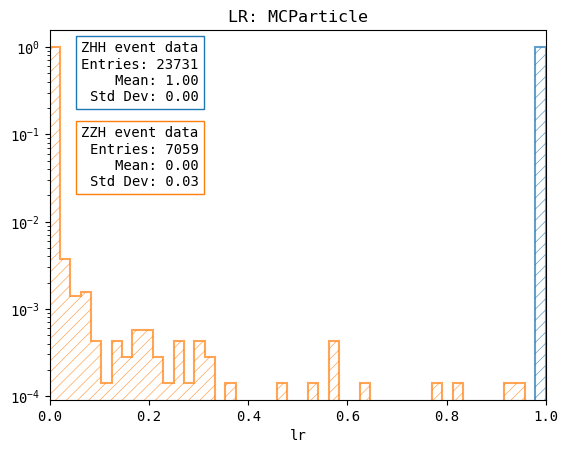

In [65]:
plot_r(mcp, "MCParticle")

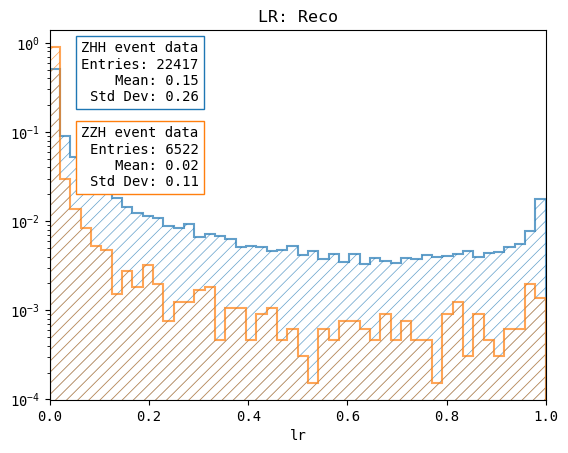

In [66]:
plot_r(reco, "Reco")

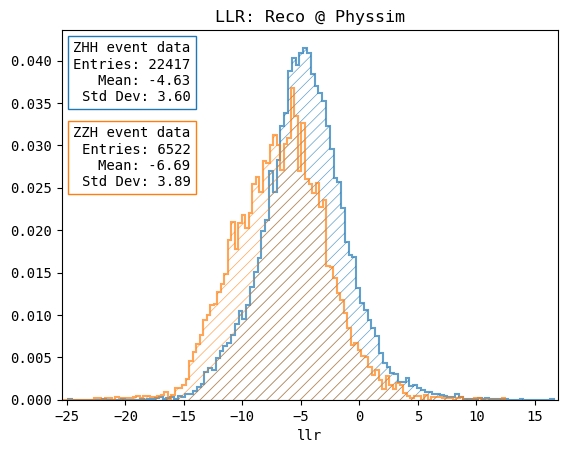

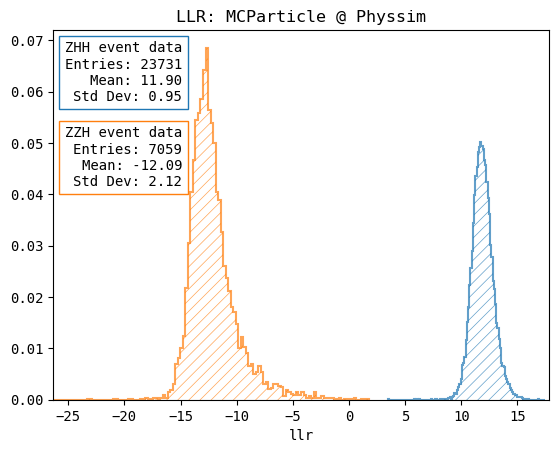

In [10]:
plot_llr(reco, "Reco @ Physsim")
plot_llr(mcp, "MCParticle @ Physsim")

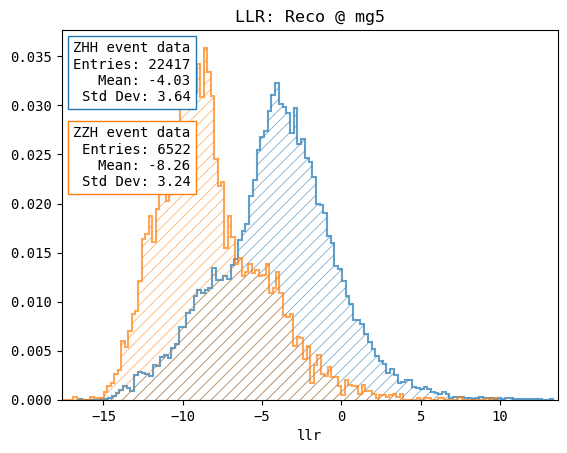

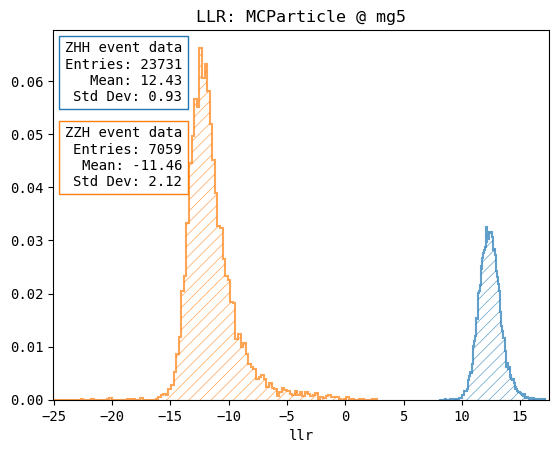

In [7]:
plot_llr(reco, "Reco @ mg5", llr_column='llr_mg5')
plot_llr(mcp, "MCParticle @ mg5", llr_column='llr_mg5')

In [9]:
from analysis.energy_transfer import plot_jet_energy_transfer_from_df, plot_energy_transfer

Jet Energy Transfer

In [68]:
import matplotlib.pyplot as plt
import logging
logger = logging.getLogger('mem_hep')

from analysis.import_data import import_data, filter_data
from analysis.plot_matplotlib import plot_hist
from math import sqrt, pow, pi, exp
from typing import Optional
from os import path as osp
from os import makedirs, remove
import numpy as np

fit_funcs = {
    "laplace": lambda x, mu, sigma:
        1/(2*sigma)*np.exp(-np.abs(x-mu)/sigma),
        
    "lorentz": lambda x, x0, gamma:
            1/(pi*gamma*(1 + ( (x-x0)/gamma )**2 )),
        
    "gauss": lambda x, x0, sigma:
        1/(sqrt(2*pi)*sigma)*np.exp(-(x-x0)**2/(2*sigma**2)),
    
    "dbgauss_old": lambda x, x0, sigma, a2, x02, sigma2:
        1/(sqrt(2*pi)*(sigma + sigma2*a2**2))*(np.exp(-(x-x0)**2/(2*sigma**2)) + (a2**2)*np.exp(-(x-x02)**2/(2*sigma2**2)))
}

def plot_transfer(data, name, plot_save_dir:Optional[str] = None, fit = "gauss", true_label = "parton", reco_label = "jet", quantity="E", xlabel=r"$ΔE$ [GeV]", xlim=(-100,100), ylim=(0, 0.18), n_bins=128, binrange=None, fit_init=None, fit_skip=False, yscale="linear"):
    from scipy.optimize import curve_fit,minimize
    
    fig, axes = plt.subplots(1, len(data), figsize=(6*len(data),8))
    fig.suptitle(name + r": $" + quantity + r"_{" + reco_label + r"}-" + quantity +  r"_{" + true_label + r"}$", fontsize=18)
    
    for i in range(1,1+len(data)):
        df = data[i-1]
        
        def dbgauss_construct(E_p, E_j):
            def dbgauss(a1, a2, a4, a5, b1, b2, b3, b4, b5):
                p1 = a1 + E_p*b1
                p2 = a2 + E_p*b2
                p3 =      E_p*b3
                p4 = a4 + E_p*b4
                p5 = a5 + E_p*b5
                
                return (1/(sqrt(2*pi)*(p2+p3*p5)))*(np.exp(-((E_j-E_p)-p1)**2/(2*p2**2)) + p3*np.exp(-((E_j-E_p) - p4)**2/(2*p5**2)))
            
            return dbgauss
        
        def dbgauss_likelihood(E_p, E_j):
            dbgauss = dbgauss_construct(E_p, E_j)
            def likelihood(a1, a2, a4, a5, b1, b2, b3, b4, b5):
                return np.sum(np.log(dbgauss(a1, a2, a4, a5, b1, b2, b3, b4, b5)))
        
        popt = None
        pcov = None
        
        if fit == "dbgauss":
            # Unbinned likelihood fit
            minimize(dbgauss_likelihood())
        else:
            # Binned fit
            df = df[0] - df[1]
            
            fit_inits = {
                "laplace": [np.average(df), 5],
                "lorentz": [np.average(df), 2],
                "gauss": [np.average(df), np.std(df)],
                "dbgauss_old": [0, np.std(df), 0.2, 0, 2*np.std(df)]
            }
            
            fit_func = fit_funcs[fit]
            fit_init_c = (fit_inits[fit] if fit_init is None else fit_init[i-1])
            
            y, bins = np.histogram(df, bins=n_bins, density=True, range=binrange)
            x = (bins[:-1] + bins[1:]) / 2
            
            if fit_skip == True:
                popt = fit_init_c
            else:
                popt, pcov = curve_fit(fit_func, x, y, p0=fit_init_c, maxfev = 8000)
        
            print(popt)

        plot_hist(df, f"{reco_label.title()} {i}", fit_func=lambda x: fit_func(x, *popt), fit_opts=popt, bins=n_bins, xlim=xlim, ylim=ylim, ax=axes[i-1], xlabel=xlabel, title=f"{reco_label.title()} {i}", normalize=True, yscale=yscale, text_spacing_y=0.15)
        #sns.histplot(data["jet{}_e".format(i)] - data["parton{}_e".format(i)], bins=128, ax=axes[i-1]).set_title("Jet {}".format(i))

def plot_transfer_from_df(data, name = "", plot_save_dir:Optional[str] = None, fit = "gauss", yscale="linear"):
    df = []
    for i in range(1, 5):
        df.append((data[f"jet{i}_e"], data[f"parton{i}_e"]))
    
    plot_transfer(df, name, plot_save_dir=plot_save_dir, fit=fit, yscale=yscale)

[-0.99692351  6.14668433]
[-1.02718438  6.27770407]
[-1.38580004  6.52747822]
[-1.20268923  6.42380481]


/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/MEM_HEP/analysis/plot_matplotlib.py:204: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(ylim)


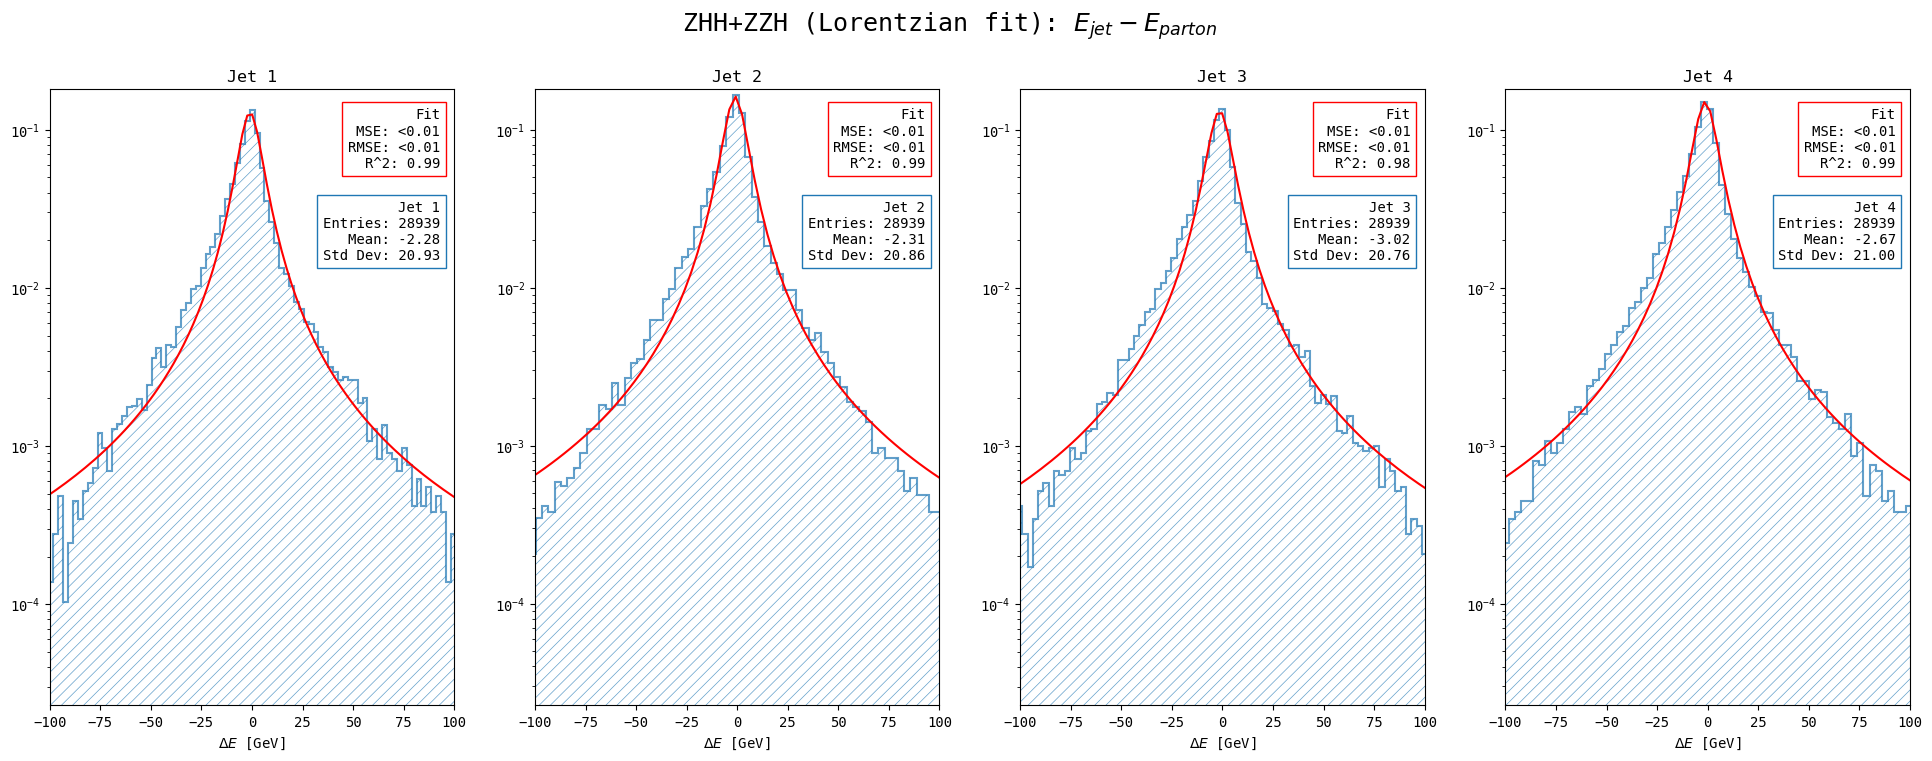

In [69]:
plot_transfer_from_df(reco, "ZHH+ZZH (Lorentzian fit)", fit="lorentz", yscale="log")

[-0.70306152  3.89696966  0.59083129 -4.56093123 17.80342971]
[-0.7306434   4.04608027  0.58132723 -4.65518564 18.45791376]
[-1.04044312  4.37318505  0.59144774 -5.86330006 18.44132398]
[-0.85900886  4.12788927  0.59635451 -5.0760122  18.29031436]


/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/MEM_HEP/analysis/plot_matplotlib.py:204: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(ylim)


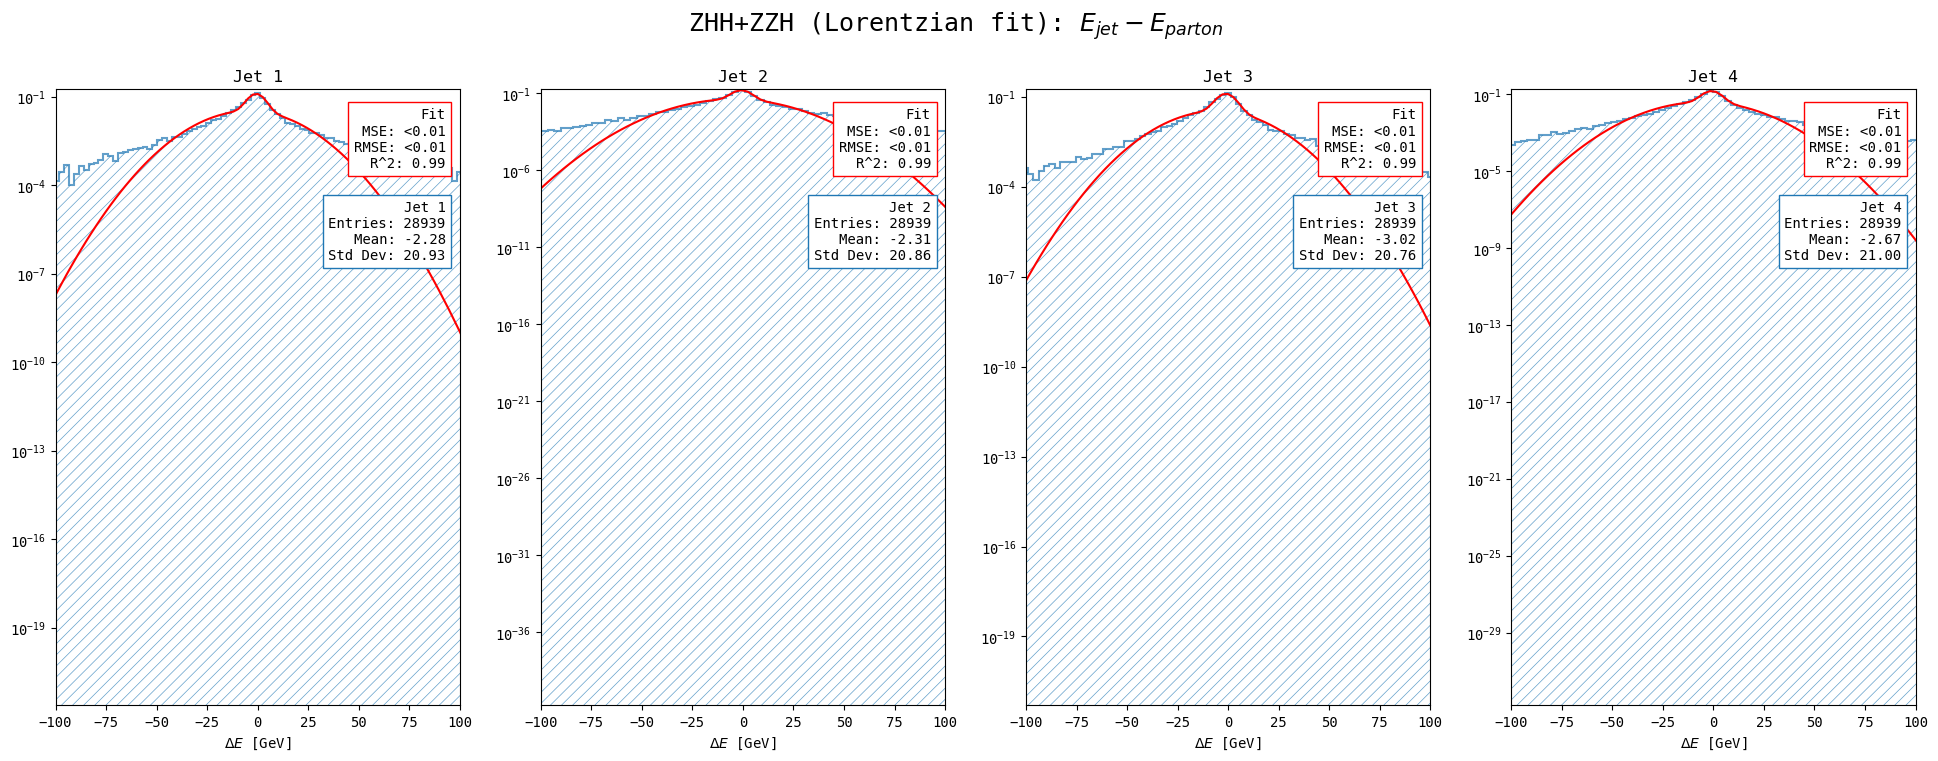

In [70]:
plot_transfer_from_df(reco, "ZHH+ZZH (Lorentzian fit)", fit="dbgauss_old", yscale="log")

In [27]:
# Check normalization of dbgauss
from scipy.integrate import quad

#E_p = np.array([1]*5)
#E_j = np.array([0]*5)
p_test = [1]*9

def dbgauss_construct(E_p, E_j):
    def dbgauss(a1, a2, a4, a5, b1, b2, b3, b4, b5):
        p1 = a1 + E_p*b1
        p2 = a2 + E_p*b2
        p3 =      E_p*b3
        p4 = a4 + E_p*b4
        p5 = a5 + E_p*b5
        
        return (1/(sqrt(2*pi)*(p2+p3*p5)))*(np.exp(-((E_j-E_p)-p1)**2/(2*p2**2)) + p3*np.exp(-((E_j-E_p) - p4)**2/(2*p5**2)))
    
    return dbgauss

def dbgauss_test(E_p):
    return dbgauss_construct(E_p, 3000)(*p_test)

#dbgauss_test(1)
quad(dbgauss_test, -500000, 500000)

(0.6386920728227685, 1.075138596520517e-09)

In [ ]:
"lorentz": lambda x, x0, gamma:
                     1/(pi*gamma*(1 + ( (x-x0)/gamma )**2 ))

In [37]:
# Check normalization of lorentz
from scipy.integrate import quad

def lorentz(x, x0, gamma):
    #return G/((2*pi)*((x-x0)**2 + ((G**2)/4)))
    return 1/(pi*gamma*(1 + ( (x-x0)/gamma )**2 ))

def lorentz_fit(x):
    popt = [-1.33850763,  6.35057887]
    return bw(x, *popt)

quad(lorentz_fit, -500000, 500000)

(0.9999919141918524, 8.87321588513478e-09)

[-1.33850763  6.35057887]
[-1.36678223  6.4788703 ]
[-1.42685018  6.48213426]
[-1.20858859  6.40604084]


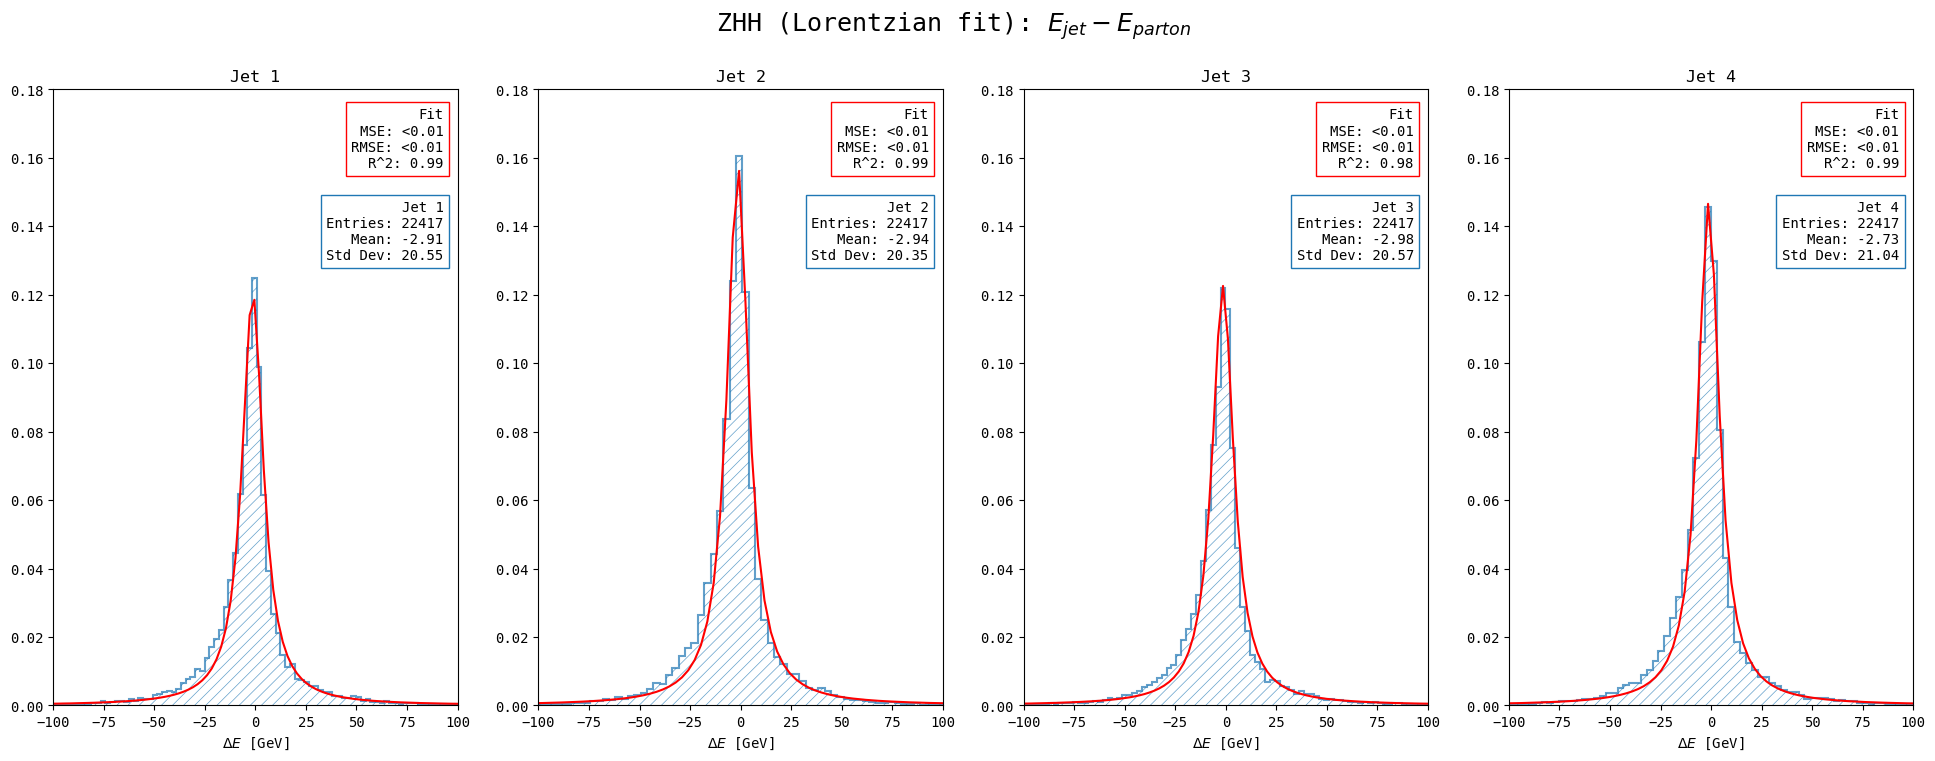

In [7]:
plot_transfer_from_df(reco[reco["is_zhh"] == 1], "ZHH (Lorentzian fit)", fit="lorentz")

[-0.21426421  5.4111742 ]
[-0.07810281  5.41453075]
[-1.3032832   6.58035589]
[-1.23814498  6.50253684]


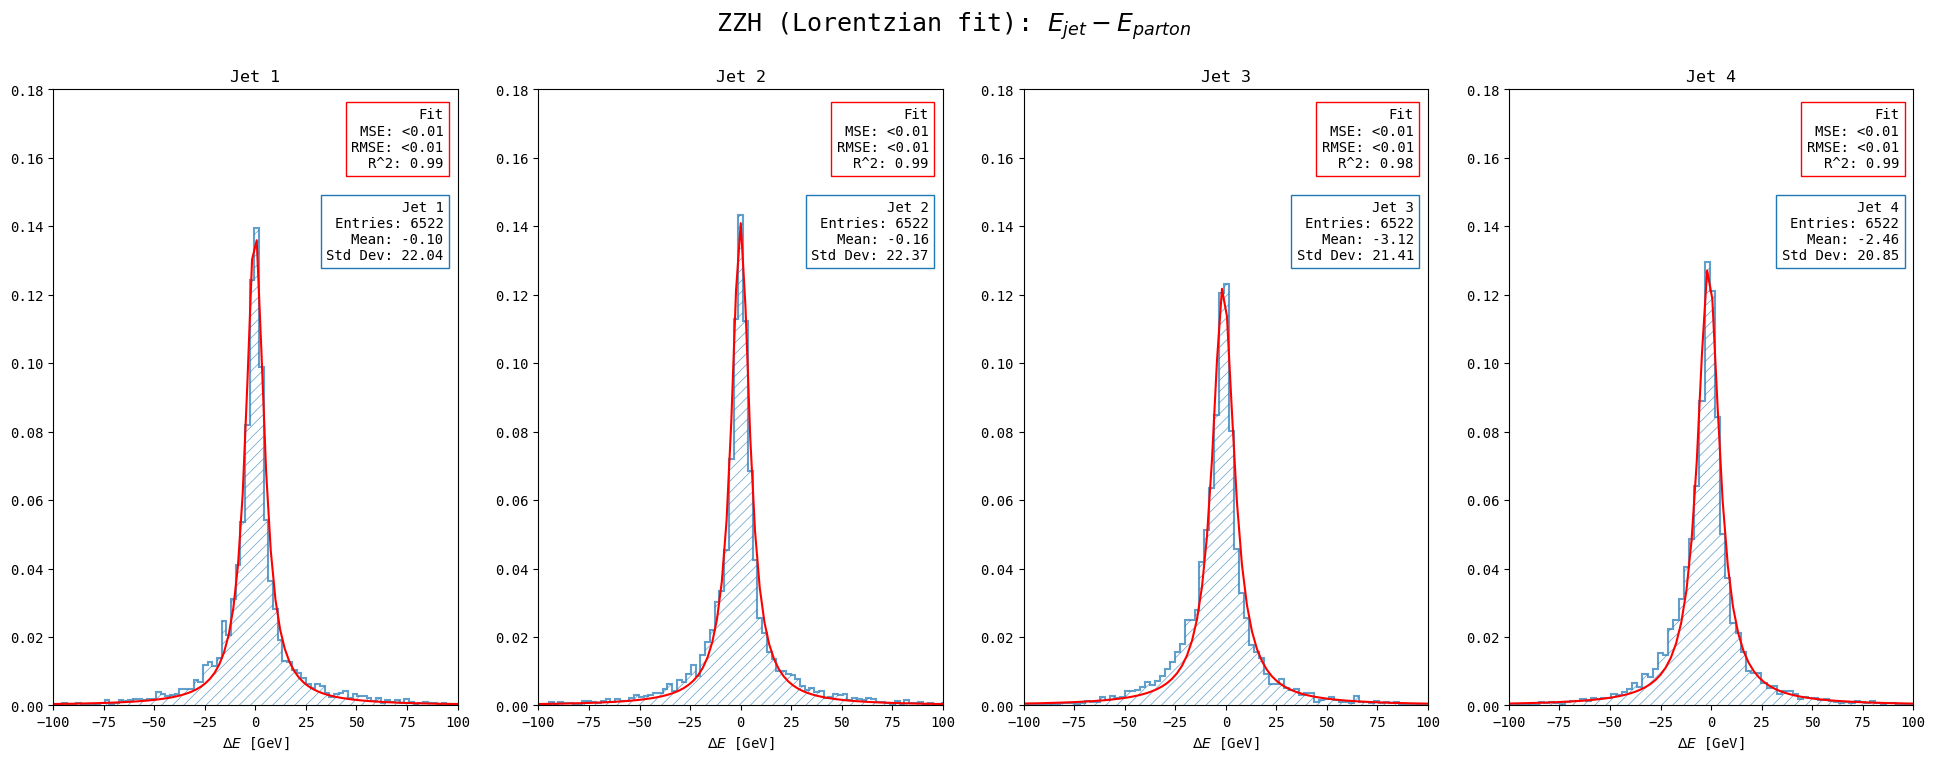

In [8]:
plot_transfer_from_df(reco[reco["is_zzh"] == 1], "ZZH (Lorentzian fit)", fit="lorentz")

pT

[-2.02830254  4.35893197]
[-2.02413195  4.53581626]
[-2.34425106  4.72286748]
[-2.24864263  4.60622201]


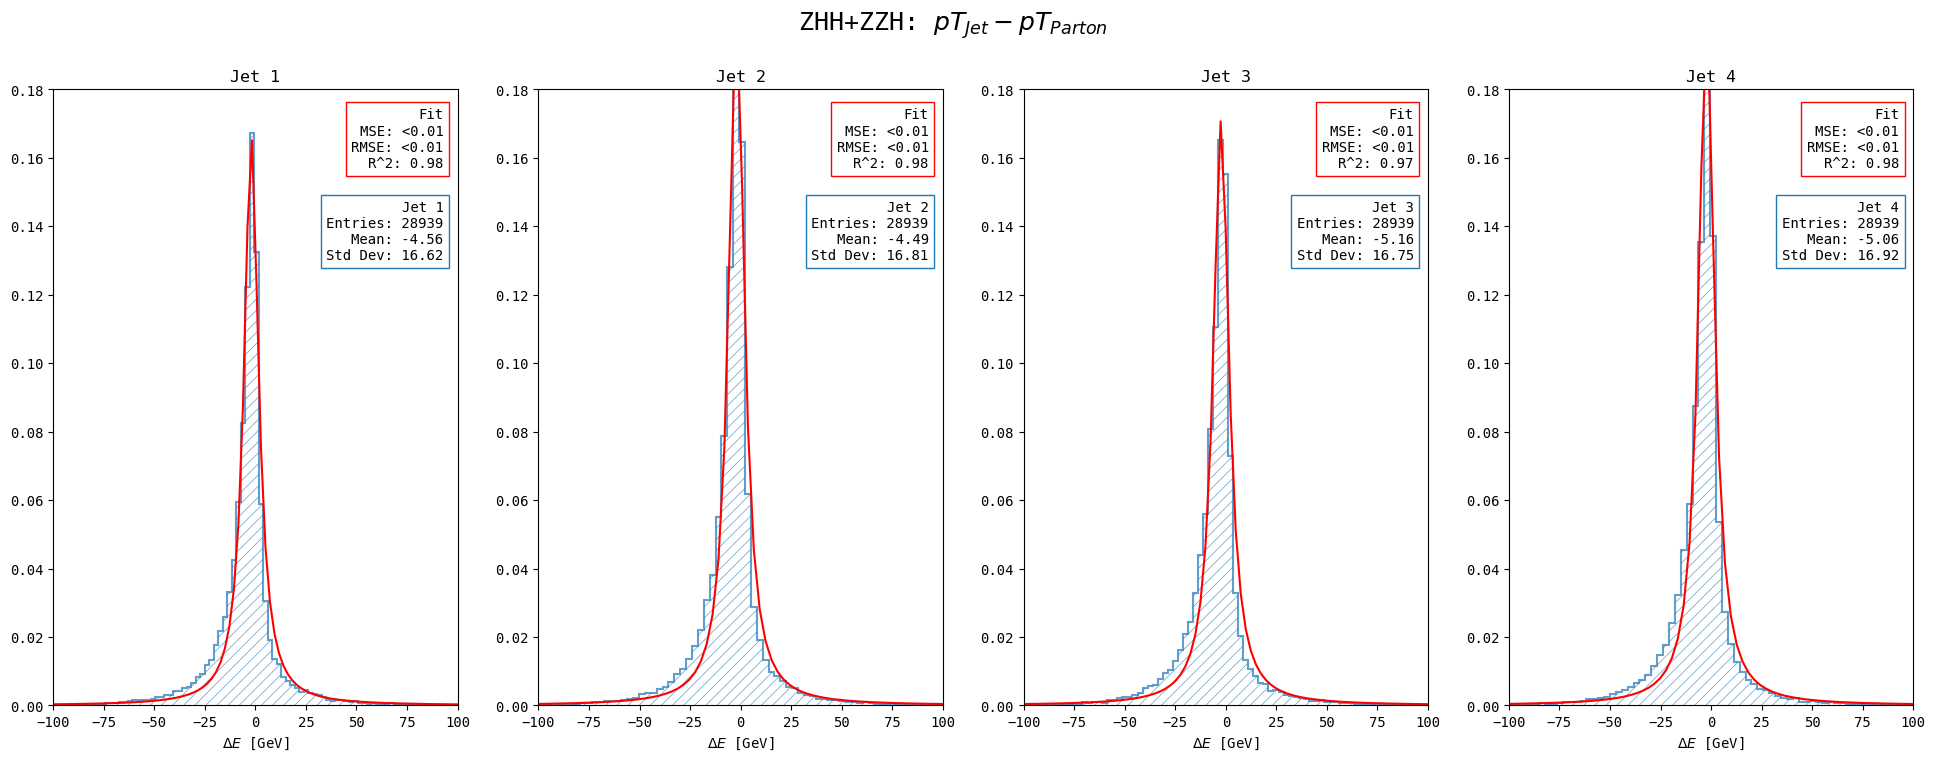

In [62]:
df = []
for i in range(1, 5):
    df.append((
        np.sqrt(reco["jet{}_px".format(i)]**2 + reco["jet{}_py".format(i)] ** 2),
        np.sqrt(reco["parton{}_px".format(i)]**2 + reco["parton{}_py".format(i)] ** 2)
    ))

plot_transfer(df, name="ZHH+ZZH", fit="lorentz", true_label="Parton", reco_label="Jet", quantity="pT")

Muon energies + angles

[-0.26770978  1.20645817  0.16674091 -1.60947224 68.54257242]
[-0.40294954  1.1472375   0.16299994 -0.56050295 68.41215147]


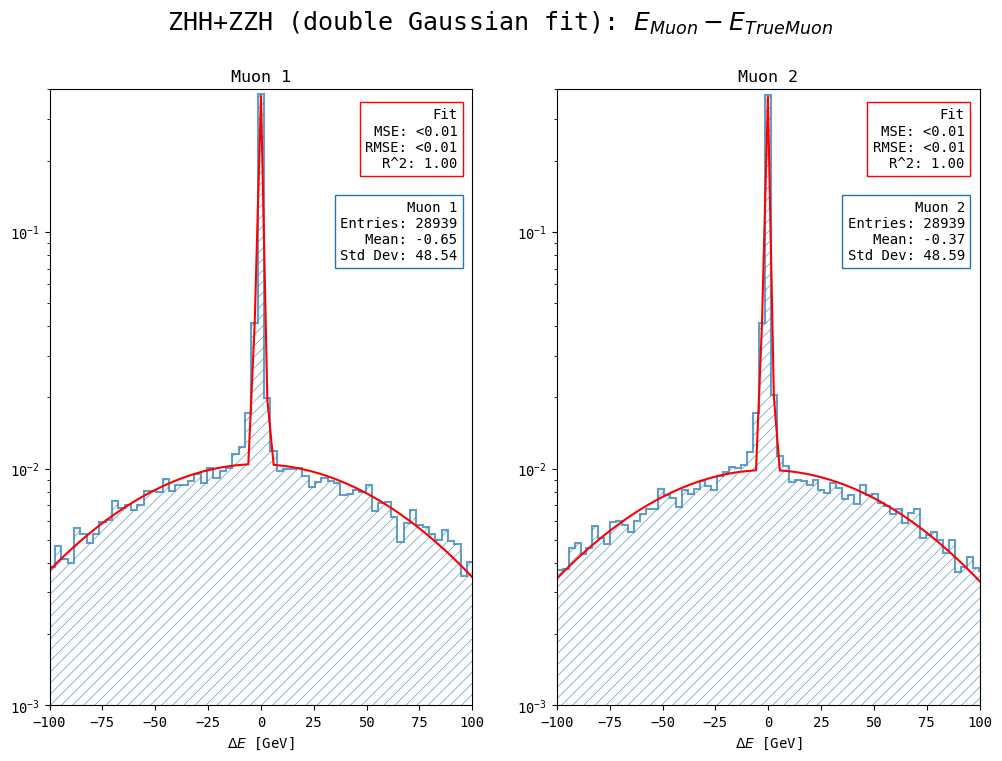

In [72]:
df = []
fit_init = []
for i in range(1, 3):
    df.append((reco[f"lep{i}_e"], reco[f"true_lep{i}_e"]))
    std_dev = np.std(reco[f"lep{i}_e"] - reco[f"true_lep{i}_e"])
    fit_init.append([0, 10, 0.1, 0, 100])    

plot_transfer(df, "ZHH+ZZH (double Gaussian fit)", fit="dbgauss_old", true_label="True Muon", reco_label="Muon", fit_init=fit_init, ylim=(0.001, 0.4), yscale="log")

In [83]:
df = []
fit_init = []
for i in range(1, 3):
    theta = {}
    phi = {}
    for ptype in ["lep", "true_lep"]:
        theta[ptype] = np.arccos(data[f"{ptype}{i}_pz"] / np.sqrt(data[f"{ptype}{i}_px"]**2 + data[f"{ptype}{i}_py"]**2 + data[f"{ptype}{i}_pz"]**2))
        phi[ptype] = np.arctan2(data[f"{ptype}{i}_py"], data[f"{ptype}{i}_px"])
    
    df.append((theta, phi))

[-0.00480873  0.00601118  0.11682099  0.89792632  0.61774417]
[ 0.00463754  0.00588112  0.11572021 -0.8967395   0.61939501]


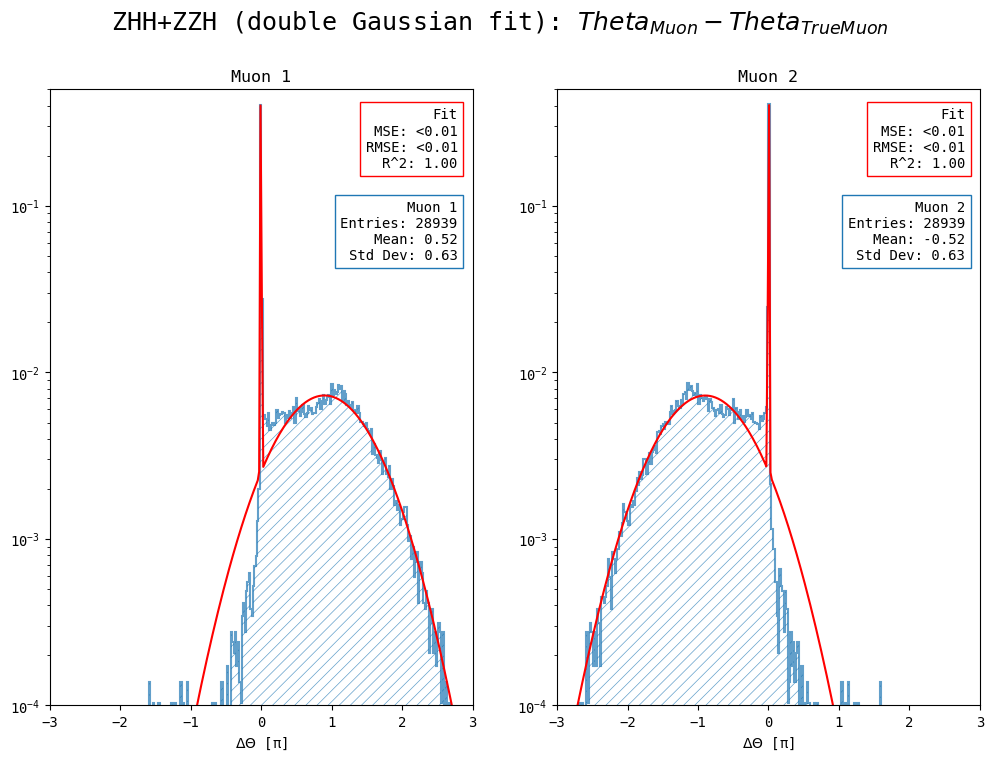

In [110]:
dg = []
fit_init = []
for i in range(2):
    dg.append((df[i][0]["lep"], df[i][0]["true_lep"]))
    fit_init.append([0, 0.1, 0.08, 0, 0.8])

plot_transfer(dg, "ZHH+ZZH (double Gaussian fit)", fit="dbgauss_old", quantity="Theta", xlabel=r"$\Delta\Theta$ [π]", true_label="True Muon", reco_label="Muon", fit_init=fit_init, xlim=(-3,3), ylim=(0.0001, 0.5), n_bins=256, yscale="log")

Jet Angular Transfer

Theta

In [75]:
data = reco

In [76]:
df = []

for i in range(1, 5):
    theta = {}
    phi = {}
    for ptype in ["jet", "parton"]:
        theta[ptype] = np.arccos(data[f"{ptype}{i}_pz"] / np.sqrt(data[f"{ptype}{i}_px"]**2 + data[f"{ptype}{i}_py"]**2 + data[f"{ptype}{i}_pz"]**2))
        phi[ptype] = np.arctan2(data[f"{ptype}{i}_py"], data[f"{ptype}{i}_px"])
    
    #theta = acos(z/sqrt(x**2 + y**2 + z**2))
    #phi = atan2(y, x)
    
    df.append((theta, phi))

Theta

[-1.38006290e-04  1.29029763e-02  4.21039384e-01  9.22202237e-04
  8.71097249e-02]
[-5.40071642e-05  1.31382925e-02  4.23296947e-01 -1.21410360e-03
  8.79496938e-02]
[ 4.78918940e-05  1.28423981e-02  4.36988569e-01 -3.57260891e-04
  8.45886315e-02]
[-9.07817865e-05  1.31156982e-02  4.23715660e-01  3.87447838e-04
  8.81337950e-02]


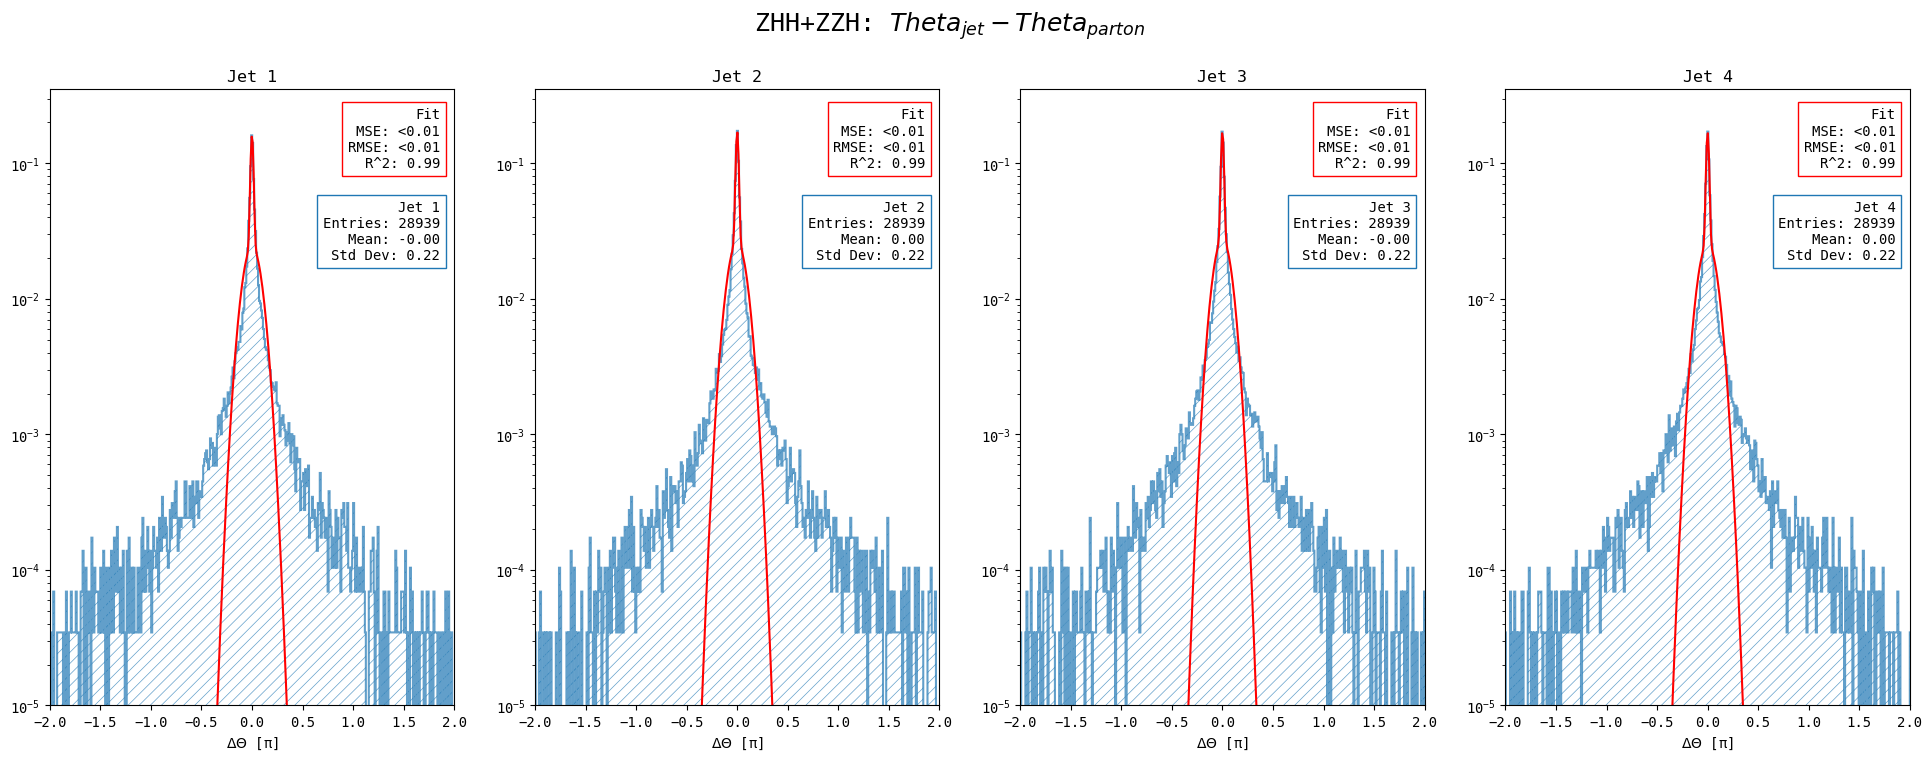

In [81]:
dg = []
fit_init = []
for i in range(4):
    dg.append((df[i][0]["jet"], df[i][0]["parton"]))
    fit_init.append([0, 0.1, 0.08, 0, 0.8])

plot_transfer(dg, "ZHH+ZZH", fit="dbgauss_old", quantity="Theta", xlabel=r"$\Delta\Theta$ [π]", xlim=(-2,2), binrange=(-2,2), ylim=(0.00001,0.35), fit_skip=False, n_bins=512, fit_init=fit_init, yscale="log")

[-6.73940009e-05  1.92978093e-02]
[-6.16711598e-05  1.97475713e-02]
[4.01437425e-05 1.97618794e-02]
[1.71684346e-05 1.97237928e-02]


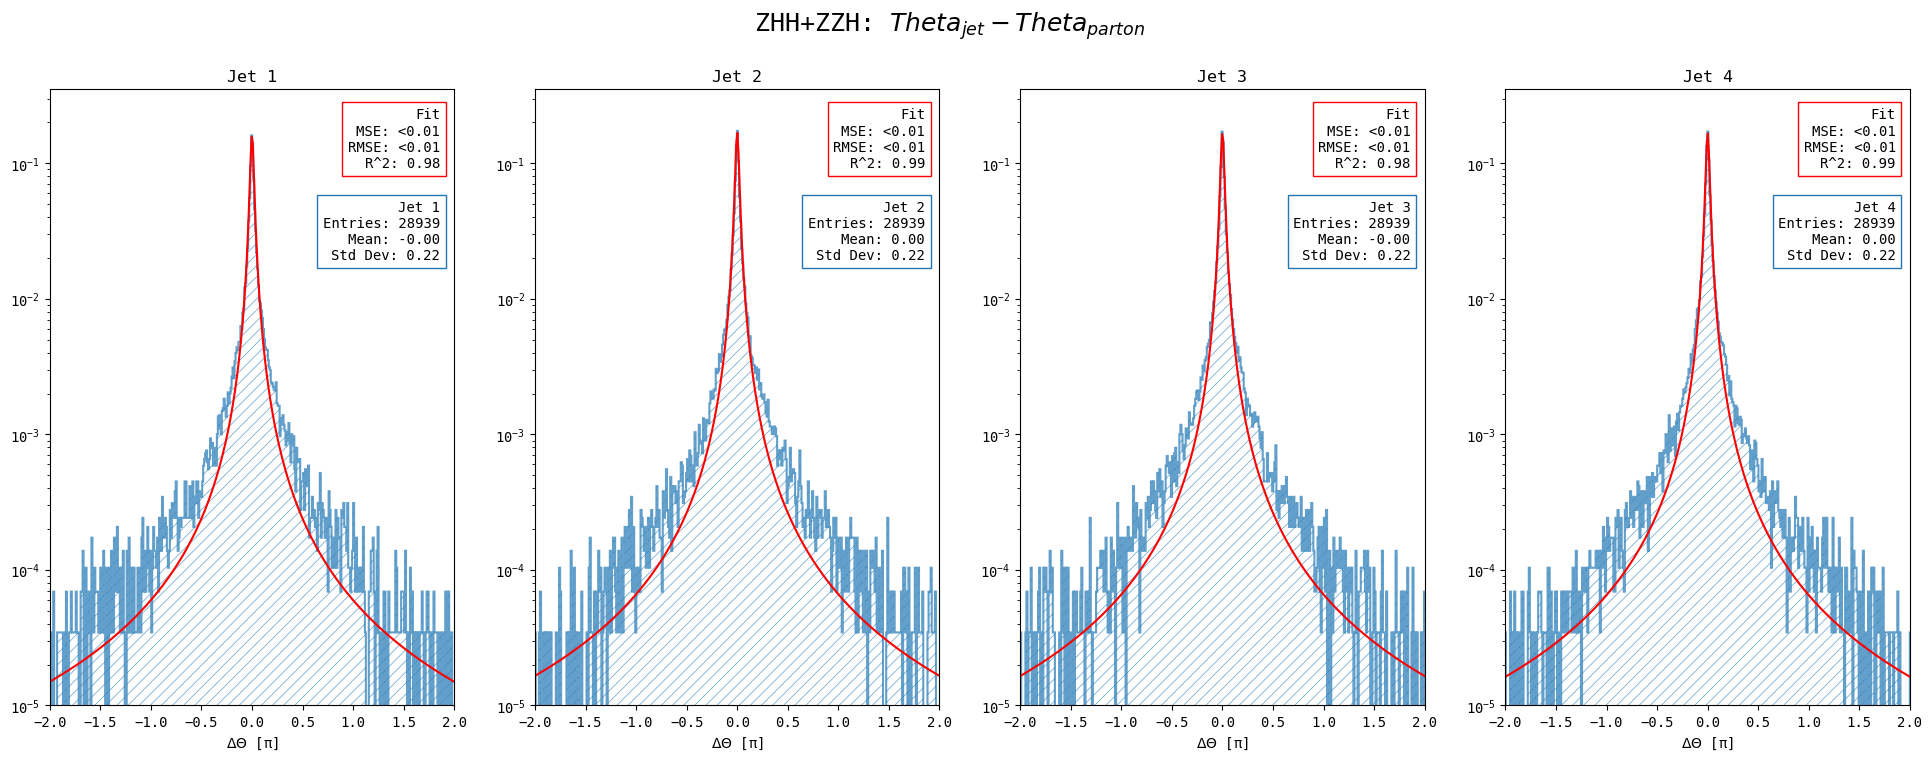

In [69]:
dg = []
for i in range(4):
    dg.append((df[i][0]["jet"], df[i][0]["parton"]))

plot_transfer(dg, "ZHH+ZZH", fit="lorentz", quantity="Theta", xlabel=r"$\Delta\Theta$ [π]", xlim=(-2,2), ylim=(0.00001,0.35), n_bins=512, yscale="log")

[7.25520248e-05 1.41488055e-02]
[-1.21860464e-05  1.43008677e-02]
[-0.00020607  0.01421485]
[0.0001609  0.01452313]


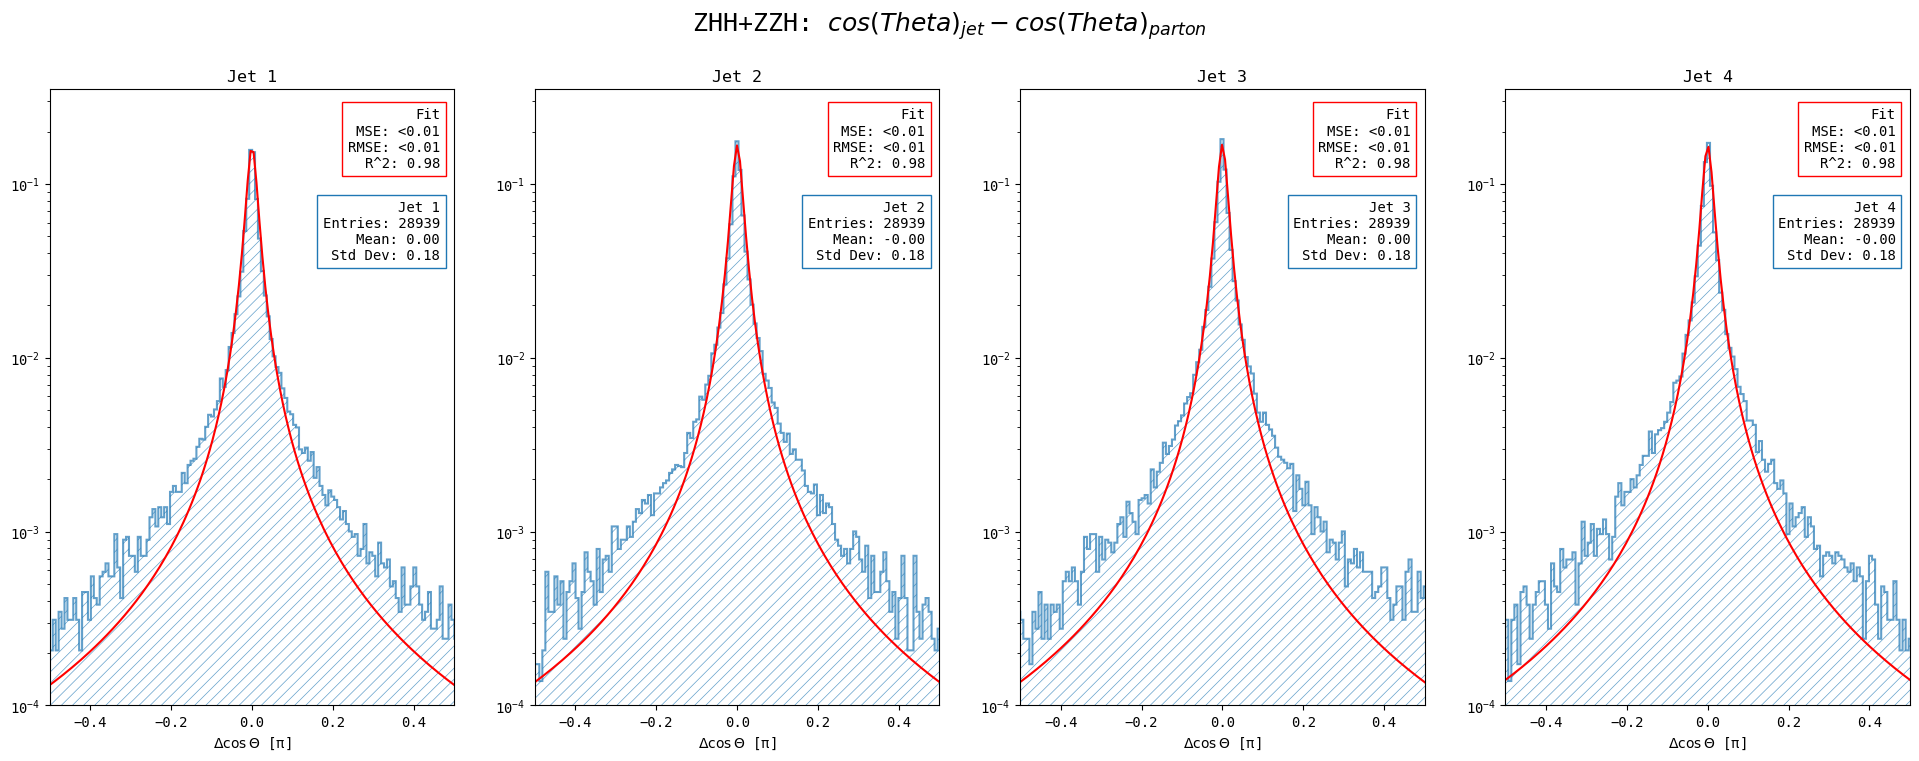

In [84]:
dg = []
for i in range(4):
    dg.append((np.cos(df[i][0]["jet"]), np.cos(df[i][0]["parton"])))

plot_transfer(dg, "ZHH+ZZH", fit="lorentz", quantity="cos(Theta)", xlabel=r"$\Delta\cos{\Theta}$ [π]", xlim=(-0.5,0.5), ylim=(0.0001,0.35), n_bins=512, yscale="log")

Phi

[0.00062912 0.02822982]
[0.00059001 0.02783513]
[-2.34602440e-06  2.82045433e-02]
[-0.00043269  0.02854085]


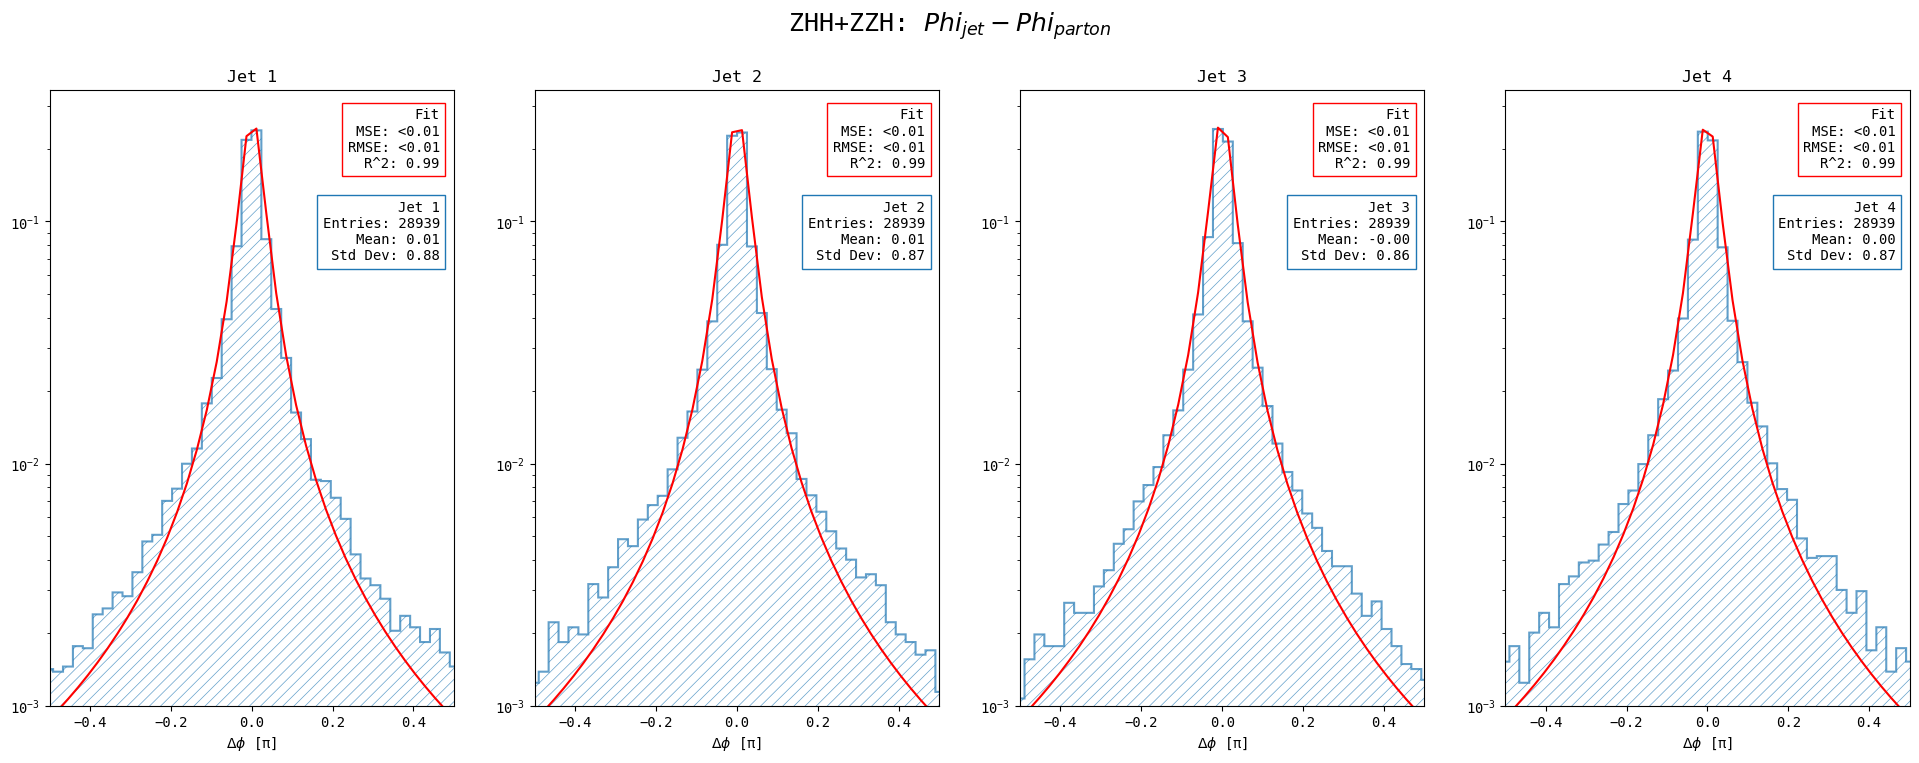

In [81]:
dg = []
for i in range(4):
    dg.append((df[i][1]["jet"], df[i][1]["parton"]))

plot_transfer(dg, "ZHH+ZZH", fit="lorentz", quantity="Phi", xlabel=r"$\Delta\phi$ [π]", xlim=(-0.5,0.5), ylim=(0.001,0.35), n_bins=512, yscale="log")

[0.00078317 0.02199607]
[0.00059999 0.02076936]
[0.00016838 0.0201623 ]
[-0.00045808  0.02265684]


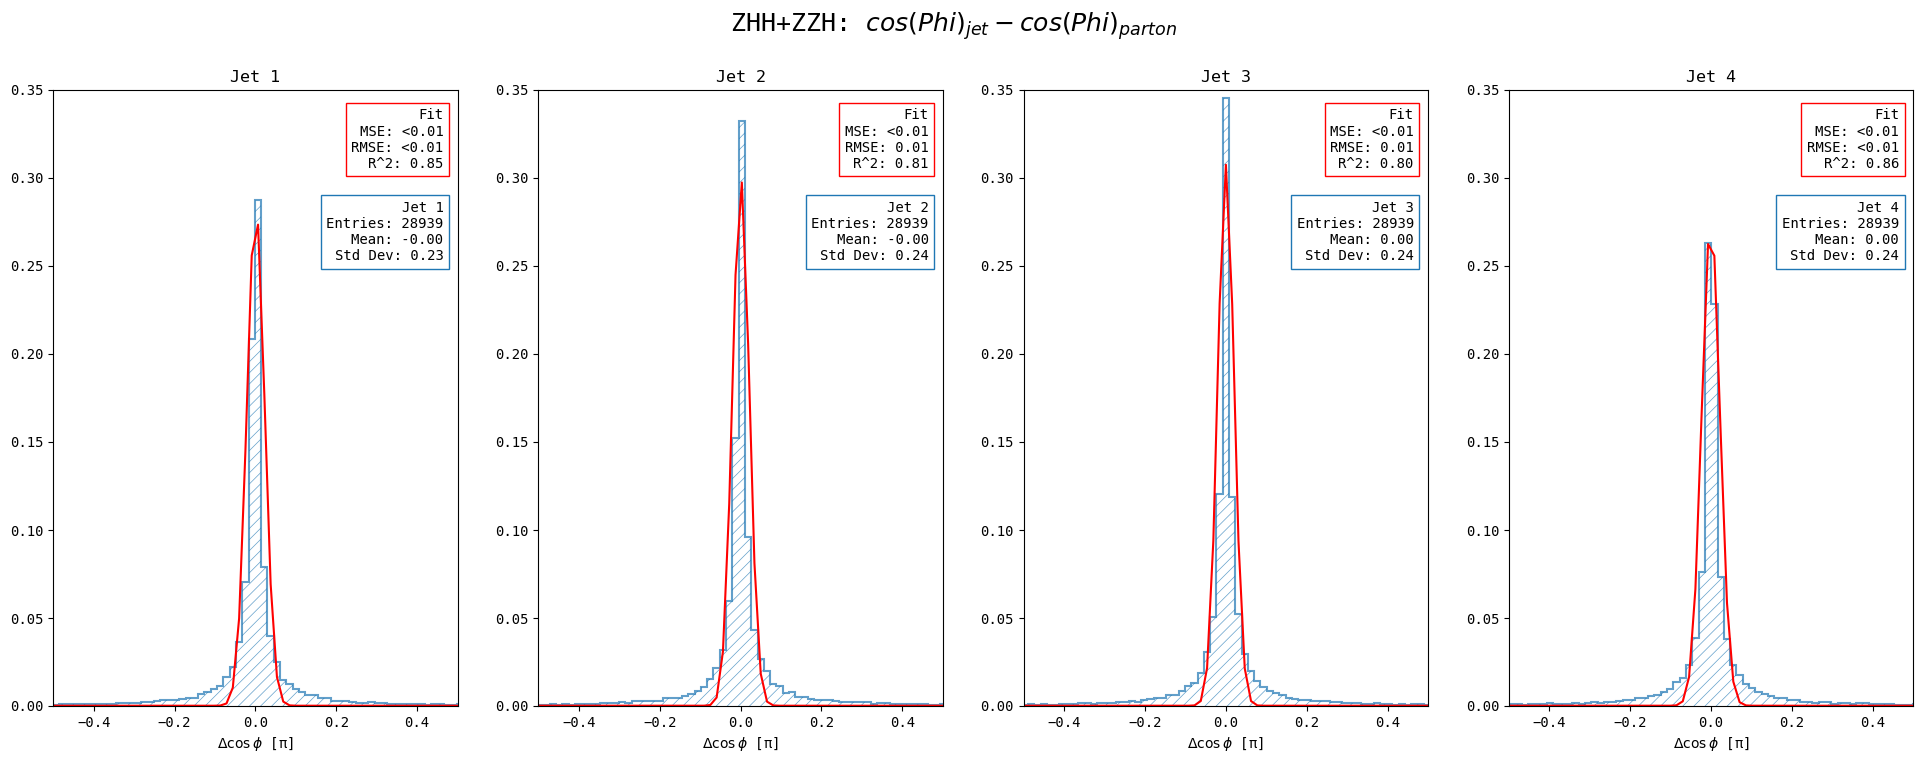

In [165]:
dg = []
for i in range(4):
    dg.append((np.cos(df[i][1]["jet"]), np.cos(df[i][1]["parton"])))

plot_transfer(dg, "ZHH+ZZH", fit="gauss", quantity="cos(Phi)", xlabel=r"$\Delta\cos{\phi}$ [π]", xlim=(-0.5,0.5), ylim=(0,0.35), n_bins=256)

Testing

In [4]:
import scipy as sp
import numpy as np
from typing import Dict
from math import sqrt,sin,cos,atan2,acos
from scipy.optimize import least_squares

constants = {
    "m_b": 4.799957253499145, # truth MC: 4.8(?); wikipedia: 4.18
    "m_H": 125.,
    "m_Z": 91.19,
    "m_mu": 0.1056357046473643, # from average over all truth MC muon/anti-muons; wikipedia: 0.105658
    "sqrt_s": 500.,
    "sigma_sig_tot": 1., # calculated with MadGraph5 for ZHH
    "sigma_bkg_tot": 1., # calculated with MadGraph5 for ZZH
    "system_px": 0,
    "system_py": 0,
    "system_pz": 0
}

def get_angles(x, y, z):
    theta = acos(z/sqrt(x**2 + y**2 + z**2))
    phi = atan2(y, x)
    
    return (theta, phi)

def unit_vec(theta, phi):
    return np.array([
        sin(theta)*cos(phi),
        sin(theta)*sin(phi),
        cos(theta)
    ])
    
def axis_vec(axis = 0) -> list[int]:
    return np.array([
        1 if axis == 0 else 0,
        1 if axis == 1 else 0,
        1 if axis == 2 else 0
    ])
    
def get_kinematics_tf(data, idx:int, mode:int = 1, order = ["1", "2", "1", "2", "3", "4"]):
    """_summary_

    Args:
        data (_type_): event data
        idx (int): _description_
        mode (int, optional): 1 = Reco (default); 0 = MC Truth

    Returns:
        _type_: _description_
    """
    p = "jet" if mode == 1 else "parton"
    l = "lep" if mode == 1 else "true_lep"
    
    angles = np.array([
        get_angles(data[f"{l}{order[0]}_px"][idx], data[f"{l}{order[0]}_py"][idx], data[f"{l}{order[0]}_pz"][idx]),
        get_angles(data[f"{l}{order[1]}_px"][idx], data[f"{l}{order[1]}_py"][idx], data[f"{l}{order[1]}_pz"][idx]),
        get_angles(data[f"{p}{order[2]}_px"][idx], data[f"{p}{order[2]}_py"][idx], data[f"{p}{order[2]}_pz"][idx]),
        get_angles(data[f"{p}{order[3]}_px"][idx], data[f"{p}{order[3]}_py"][idx], data[f"{p}{order[3]}_pz"][idx]),
        get_angles(data[f"{p}{order[4]}_px"][idx], data[f"{p}{order[4]}_py"][idx], data[f"{p}{order[4]}_pz"][idx]),
        get_angles(data[f"{p}{order[5]}_px"][idx], data[f"{p}{order[5]}_py"][idx], data[f"{p}{order[5]}_pz"][idx])
    ])
    
    energies = np.array([
        data[f"{l}{order[0]}_e"][idx],
        data[f"{l}{order[1]}_e"][idx],
        data[f"{p}{order[2]}_e"][idx],
        data[f"{p}{order[3]}_e"][idx],
        data[f"{p}{order[4]}_e"][idx],
        data[f"{p}{order[5]}_e"][idx]
    ])
    
    momenta = np.array([
        sqrt(data[f"{l}{order[0]}_px"][idx]**2 + data[f"{l}{order[0]}_py"][idx]**2 + data[f"{l}{order[0]}_pz"][idx]**2),
        sqrt(data[f"{l}{order[1]}_px"][idx]**2 + data[f"{l}{order[1]}_py"][idx]**2 + data[f"{l}{order[1]}_pz"][idx]**2),
        sqrt(data[f"{p}{order[2]}_px"][idx]**2 + data[f"{p}{order[2]}_py"][idx]**2 + data[f"{p}{order[2]}_pz"][idx]**2),
        sqrt(data[f"{p}{order[3]}_px"][idx]**2 + data[f"{p}{order[3]}_py"][idx]**2 + data[f"{p}{order[3]}_pz"][idx]**2),
        sqrt(data[f"{p}{order[4]}_px"][idx]**2 + data[f"{p}{order[4]}_py"][idx]**2 + data[f"{p}{order[4]}_pz"][idx]**2),
        sqrt(data[f"{p}{order[5]}_px"][idx]**2 + data[f"{p}{order[5]}_py"][idx]**2 + data[f"{p}{order[5]}_pz"][idx]**2)        
    ])
    
    return (energies, momenta, angles)

def get_corrections(data, event_idx:int, is_reco:int = 1):
    qties = (
        [],
        [],
        [],
        []
    )
    for i, qty in enumerate(["e", "px", "py", "pz"]):
        for part in (["lep1", "lep2", "jet1", "jet2", "jet3", "jet4"] if is_reco else ["true_lep1", "true_lep2", "parton1", "parton2", "parton3", "parton4"]):
            qties[i].append(data[f"{part}_{qty}"][event_idx])
            
    return {
        "sqrt_s": np.sum(qties[0]),
        "system_px": np.sum(qties[1]),
        "system_py": np.sum(qties[2]),
        "system_pz": np.sum(qties[3]),
    }

def get_parton_energies(data, event_idx):
    return [
        data["parton1_e"][event_idx],
        data["parton2_e"][event_idx],
        data["parton3_e"][event_idx],
        data["parton4_e"][event_idx]
    ]

def get_all_momenta(data, event_idx:int, as_4_vectors=False, is_reco=False):
    return np.concatenate(
        (get_lepton_momenta(data, event_idx, as_4_vectors, is_reco), get_parton_momenta(data, event_idx, as_4_vectors, is_reco))
    )
 
def get_parton_momenta(data, event_idx:int, as_4_vectors=False, is_reco=False):
    """_summary_

    Args:
        data (_type_): _description_
        event_idx (int): _description_
        as_4_vectors (bool, optional): If True, returns 4 vectors of partons, otherwise only momenta of 3 vectors. Defaults to False.

    Returns:
        _type_: _description_
    """
    
    p = "jet" if is_reco else "parton"
    
    if as_4_vectors:
        return [
            np.array([data[f"{p}1_e"][event_idx], data[f"{p}1_px"][event_idx], data[f"{p}1_py"][event_idx], data[f"{p}1_pz"][event_idx]]),
            np.array([data[f"{p}2_e"][event_idx], data[f"{p}2_px"][event_idx], data[f"{p}2_py"][event_idx], data[f"{p}2_pz"][event_idx]]),
            np.array([data[f"{p}3_e"][event_idx], data[f"{p}3_px"][event_idx], data[f"{p}3_py"][event_idx], data[f"{p}3_pz"][event_idx]]),
            np.array([data[f"{p}4_e"][event_idx], data[f"{p}4_px"][event_idx], data[f"{p}4_py"][event_idx], data[f"{p}4_pz"][event_idx]])
        ]
    else:
        return np.array([
            sqrt(data[f"{p}1_px"][event_idx]**2 + data[f"{p}1_py"][event_idx]**2 + data[f"{p}1_pz"][event_idx]**2),
            sqrt(data[f"{p}2_px"][event_idx]**2 + data[f"{p}2_py"][event_idx]**2 + data[f"{p}2_pz"][event_idx]**2),
            sqrt(data[f"{p}3_px"][event_idx]**2 + data[f"{p}3_py"][event_idx]**2 + data[f"{p}3_pz"][event_idx]**2),
            sqrt(data[f"{p}4_px"][event_idx]**2 + data[f"{p}4_py"][event_idx]**2 + data[f"{p}4_pz"][event_idx]**2)    
        ])
        
def get_lepton_momenta(data, event_idx:int, as_4_vectors=False, is_reco=False):
    """_summary_

    Args:
        data (_type_): _description_
        event_idx (int): _description_
        as_4_vectors (bool, optional): If True, returns 4 vectors of partons, otherwise only momenta of 3 vectors. Defaults to False.

    Returns:
        _type_: _description_
    """
    
    p = "lep" if is_reco else "true_lep"
    
    if as_4_vectors:
        return [
            np.array([data[f"{p}1_e"][event_idx], data[f"{p}1_px"][event_idx], data[f"{p}1_py"][event_idx], data[f"{p}1_pz"][event_idx]]),
            np.array([data[f"{p}2_e"][event_idx], data[f"{p}2_px"][event_idx], data[f"{p}2_py"][event_idx], data[f"{p}2_pz"][event_idx]]),
        ]
    else:
        return np.array([
            sqrt(data[f"{p}1_px"][event_idx]**2 + data[f"{p}1_py"][event_idx]**2 + data[f"{p}1_pz"][event_idx]**2),
            sqrt(data[f"{p}2_px"][event_idx]**2 + data[f"{p}2_py"][event_idx]**2 + data[f"{p}2_pz"][event_idx]**2),   
        ])

Check masses

In [12]:
m_mu1 = []
m_mu2 = []
for event_idx in range(10000):
    m_mu1.append(
        sqrt(reco["true_lep1_e"][event_idx]**2 - (
            reco["true_lep1_px"][event_idx]**2 +
            reco["true_lep1_py"][event_idx]**2 +
            reco["true_lep1_pz"][event_idx]**2
        ))
    )
    
    m_mu2.append(
        sqrt(reco["true_lep2_e"][event_idx]**2 - (
            reco["true_lep2_px"][event_idx]**2 +
            reco["true_lep2_py"][event_idx]**2 +
            reco["true_lep2_pz"][event_idx]**2
        ))
    )
m_mu1 = np.array(m_mu1)
m_mu2 = np.array(m_mu2)

In [13]:
(np.average(m_mu1) + np.average(m_mu2))/2

0.1056357046473643

In [14]:
b1_m = []
b2_m = []
b3_m = []
b4_m = []

for i in range(10000):
    b1_mass = sqrt(reco["parton1_e"][event_idx]**2 - (
        reco["parton1_px"][event_idx]**2 +
        reco["parton1_py"][event_idx]**2 +
        reco["parton1_pz"][event_idx]**2
    ))
    
    b2_mass = sqrt(reco["parton2_e"][event_idx]**2 - (
        reco["parton2_px"][event_idx]**2 +
        reco["parton2_py"][event_idx]**2 +
        reco["parton2_pz"][event_idx]**2
    ))
    
    b3_mass = sqrt(reco["parton3_e"][event_idx]**2 - (
        reco["parton3_px"][event_idx]**2 +
        reco["parton3_py"][event_idx]**2 +
        reco["parton3_pz"][event_idx]**2
    ))
    
    b4_mass = sqrt(reco["parton4_e"][event_idx]**2 - (
        reco["parton4_px"][event_idx]**2 +
        reco["parton4_py"][event_idx]**2 +
        reco["parton4_pz"][event_idx]**2
    ))
    
    b1_m.append(b1_mass)
    b2_m.append(b2_mass)
    b3_m.append(b3_mass)
    b4_m.append(b4_mass)
    
    #if not b1_mass == b2_mass:
    #    print((b1_mass, b2_mass))
    
b1_m = np.array(b1_m)
b2_m = np.array(b2_m)
b3_m = np.array(b3_m)
b4_m = np.array(b4_m)

In [15]:
(np.average(b1_m), np.average(b2_m), np.average(b3_m), np.average(b4_m))

(4.799953245086451, 4.799945909454389, 4.7999932048021074, 4.799936654653635)

In [16]:
(np.average(b1_m) + np.average(b2_m) + np.average(b3_m) + np.average(b4_m))/4

4.799957253499145

# ISR(+other effects? valid conservation of four momentum in MC sample?) introduces non-zero pT and longitudinal momentum!

Plots for system px,py,pz momenta

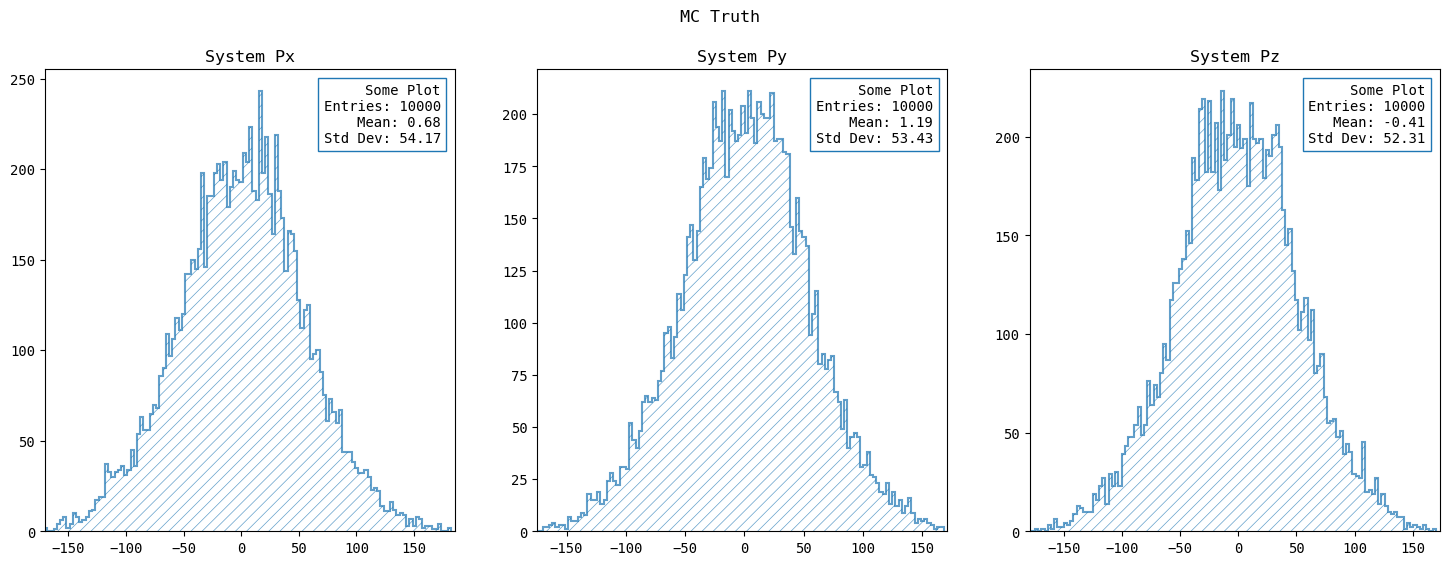

In [6]:
length = 10000
pTruth = (
    np.zeros(length),
    np.zeros(length),
    np.zeros(length)
)

for j in range(length):
    for i, qty in enumerate(["px", "py", "pz"]):
        for part in ["true_lep1", "true_lep2", "parton1", "parton2", "parton3", "parton4"]:
            pTruth[i][j] = reco[f"{part}_{qty}"][j]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("MC Truth")

plot_hist(pTruth[0], x=None, title="System Px", ax=axes[0])
plot_hist(pTruth[1], x=None, title="System Py", ax=axes[1])
plot_hist(pTruth[2], x=None, title="System Pz", ax=axes[2])

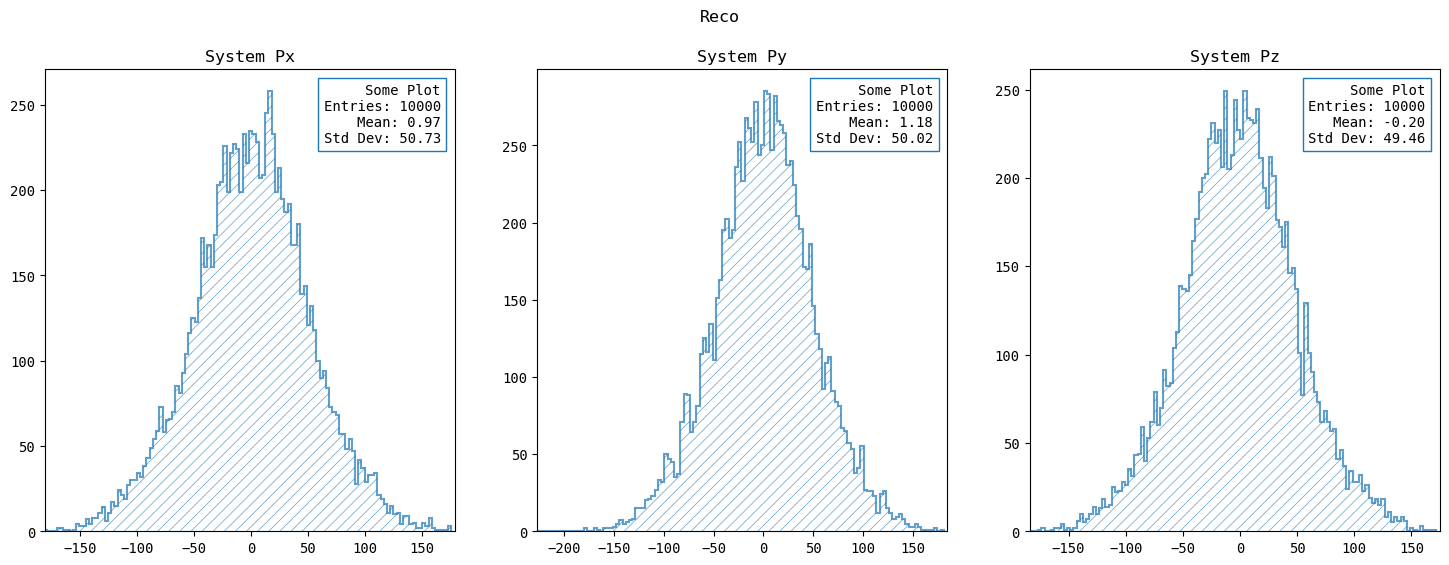

In [140]:
length = 10000
pReco = (
    np.zeros(length),
    np.zeros(length),
    np.zeros(length)
)

for j in range(length):
    for i, qty in enumerate(["px", "py", "pz"]):
        for part in ["lep1", "lep2", "jet1", "jet2", "jet3", "jet4"]:
            pReco[i][j] = reco[f"{part}_{qty}"][j]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Reco")

plot_hist(pReco[0], x=None, title="System Px", ax=axes[0])
plot_hist(pReco[1], x=None, title="System Py", ax=axes[1])
plot_hist(pReco[2], x=None, title="System Pz", ax=axes[2])

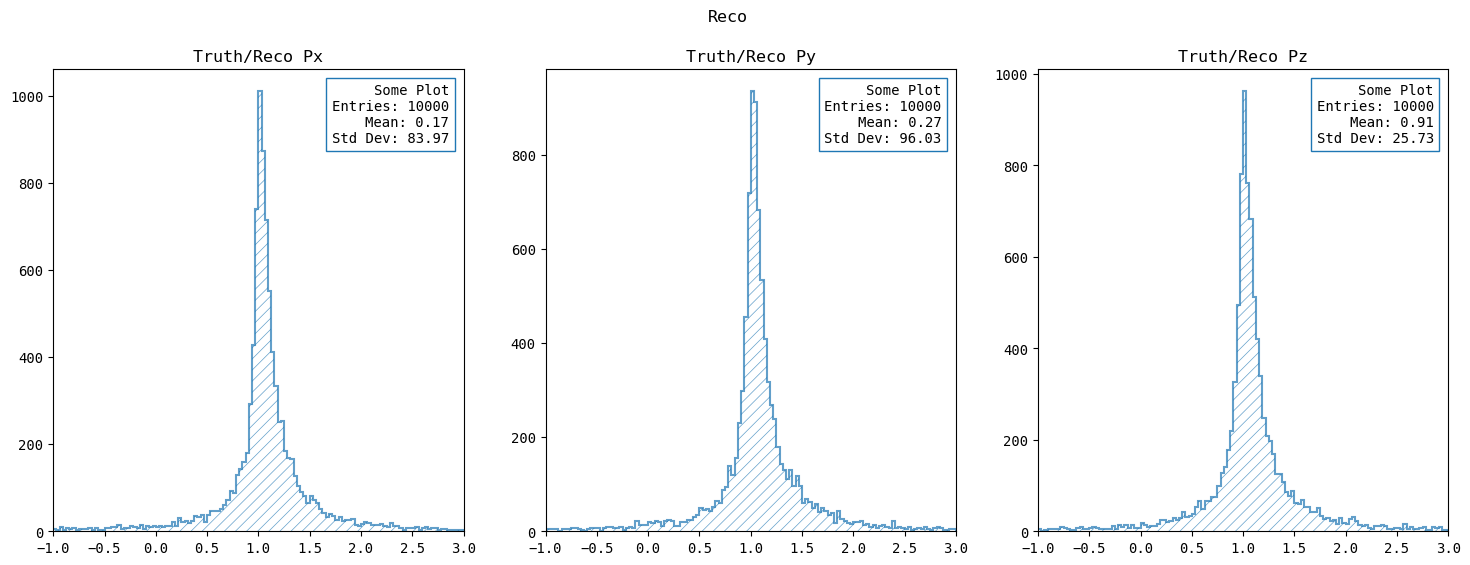

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Reco")

xlim = xlim_binning = (-1,3)
plot_hist(pTruth[0]/pReco[0], x=None, title="Truth/Reco Px", ax=axes[0], xlim_binning=xlim_binning, xlim=xlim)
plot_hist(pTruth[1]/pReco[1], x=None, title="Truth/Reco Py", ax=axes[1], xlim_binning=xlim_binning, xlim=xlim)
plot_hist(pTruth[2]/pReco[2], x=None, title="Truth/Reco Pz", ax=axes[2], xlim_binning=xlim_binning, xlim=xlim)

In [15]:
constants

{'m_b': 4.799957253499145,
 'm_H': 125.0,
 'm_Z': 91.19,
 'm_mu': 0.1056357046473643,
 'sqrt_s': 500.0,
 'sigma_sig_tot': 1.0,
 'sigma_bkg_tot': 1.0}

In [5]:
def prepare_int(data, event_idx:int, constants:dict, is_reco=True):
    """_summary_

    Args:
        data (_type_): _description_
        event_idx (int): _description_
        constants (dict): _description_
        is_reco (bool, optional): _description_. Defaults to True.

    Returns:
        _type_: _description_
    """
    
    p = "lep" if is_reco else "true_lep"
    
    mu1E = data[f"{p}1_e"][event_idx]
    mu1Th, mu1Ph = get_angles(reco[f"{p}1_px"][event_idx], reco[f"{p}1_py"][event_idx], reco[f"{p}1_pz"][event_idx])
    mu1p = unit_vec(mu1Th, mu1Ph)*sqrt(mu1E**2 - constants["m_mu"]**2)
    
    mu2E = data[f"{p}2_e"][event_idx]
    mu2Th, mu2Ph = get_angles(reco[f"{p}2_px"][event_idx], reco[f"{p}2_py"][event_idx], reco[f"{p}2_pz"][event_idx])
    mu2p = unit_vec(mu2Th, mu2Ph)*sqrt(mu2E**2 - constants["m_mu"]**2)
    
    return (
        (mu1E, mu1p),
        (mu2E, mu2p)
    )

In [17]:
prepare_int(reco, 0, constants, use_reco)

((136.98685, array([-67.09130669,  79.33933795,  89.27155813])),
 (18.425348, array([ 13.73210182, -12.27001902,   0.59859273])))

In [6]:
def Minkowski(v4):
    return v4[0]**2 - (v4[1]**2 + v4[2]**2 + v4[3]**2)

In [7]:
from math import acos,copysign,atan2,atan

In [ ]:
def spherical_to_Exyz(tuples):
    

In [63]:
def get_kinematics_from_int(int_variables, constants, mode:str = "Exyz"):
    """_summary_

    Args:
        int_variables (_type_): _description_
        constants (_type_): _description_
        mode (str, optional): Either Exyz or spherical; latter will output (E,rho,Thetha,Phi) tuples. Defaults to "Exyz".

    Returns:
        _type_: _description_
    """
    
    (mu1E, mu1p), (mu2E, mu2p), mH2, Thb1, Phb1, Rhb1, Thb1b, Phb1b, Rhb2, Thb2 = int_variables
    
    b1E = sqrt(constants["m_b"]**2 + Rhb1**2)
    b1e = unit_vec(Thb1, Phb1)
    b1p = Rhb1*b1e
    
    # Calculate Rhb1b from mH2, Rhb1 and angles
    b1be = unit_vec(Thb1b, Phb1b)
    dot = np.dot(b1e, b1be)
    
    dmH2 = (mH2-2*constants["m_b"]**2)/2
    d = (dmH2*Rhb1*dot)/(Rhb1**2*dot**2 - b1E**2)
    
    Rhb1b1 = -d + sqrt(((b1E**2)*(constants["m_b"]**2) - dmH2**2)/((Rhb1**2)*(dot**2) - b1E**2) + d**2)
    #Rhb1b2 = -d - sqrt(((b1E**2)*(constants["m_b"]**2) - dmH2**2)/((Rhb1**2)*(dot**2) - b1E**2) + d**2)
    
    b1bp1 = Rhb1b1*b1be
    #b1bp2 = Rhb1b2*b1be
    
    b1bE1 = sqrt(constants["m_b"]**2 + Rhb1b1**2)
    #b1bE2 = sqrt(constants["m_b"]**2 + Rhb1b1**2)
    
    #print("mu1", mu1E, mu1p)
    #print("mu2", mu2E, mu2p)
    
    #print("TestMu2=0", -dmH2 + b1E*b1bE1 - dot*Rhb1*Rhb1b1)
    
    # Only use one solution
    #print("b1", b1E, b1p)
    #print("b1b", b1bE1, b1bp1)
    
    # Calculate pH and from that pB2
    pB2 = np.array([
        constants["sqrt_s"] -mu1E -mu2E -(b1E+b1bE1),
        constants["system_px"] -mu1p[0] -mu2p[0] -b1p[0] -b1bp1[0],
        constants["system_py"] -mu1p[1] -mu2p[1] -b1p[1] -b1bp1[1],
        constants["system_pz"] -mu1p[2] -mu2p[2] -b1p[2] -b1bp1[2],
    ])
    
    # print("pB2", pB2, sqrt(Minkowski(pB2)))
    
    # Calculate Rhb2b
    b2E = sqrt(constants["m_b"]**2 + Rhb2**2)
    b2bE = pB2[0] - b2E
    Rhb2b = sqrt(b2bE**2 - constants["m_b"]**2)
    #print("b2", Rhb2, b2E)
    #print("b2b", Rhb2b, b2bE)
    
    # Calculate remaining variables, i.e. Thb2b, Phb2b and Phb2
    Thb2b = acos(1/Rhb2b*(pB2[3] - Rhb2*cos(Thb2)))
    
    a = pB2[1]
    b = pB2[2]
    c = (-(Rhb2*sin(Thb2))**2 + (Rhb2b*sin(Thb2b))**2 + a**2 + b**2)/(2*Rhb2b*sin(Thb2b))
    
    Phb2b = 2*atan((b+ sqrt(a**2 + b**2 - c**2))/(a+c))
    
    #print("Thb2b+Phb2b", Thb2b, Phb2b)
    #print("TestC=0", c-a*cos(Phb2b)-b*sin(Phb2b))
    
    Phb2 = acos((a - Rhb2b*sin(Thb2b)*cos(Phb2b))/(Rhb2*sin(Thb2)))
    #print("Thb2+Phb2", Thb2, Phb2)
    
    if mode == "Exyz":
        b2e = unit_vec(Thb2, Phb2)
        b2p = Rhb2*b2e
        
        b2be = unit_vec(Thb2b, Phb2b)
        b2bp = Rhb2b*b2be
        
        return (
            (mu1E, *mu1p),
            (mu2E, *mu2p),
            (b1E, *b1p),
            (b1bE1, *b1bp1),
            (b2E, *b2p),
            (b2bE, *b2bp)
        )
    elif mode == "spherical":
        return ()
    else:
        raise Exception("Invalid mode")

In [66]:
event_idx = 3

#print(evt_constants)

def get_kinematics_debug(data, event_idx, constants):
    use_reco = False
    
    energies, momenta, angles = get_kinematics_tf(data, event_idx, use_reco)

    b1angles = angles[2]
    b1bangles = angles[3]

    # Get true energy of final state particles for testing
    evt_constants = constants
    if not use_reco:
        evt_constants = evt_constants | get_corrections(data, event_idx, use_reco) # shallow copy, then replacing entries in constants with those from get_corrections
        evt_constants["sqrt_s"] = np.sum(energies)
        
    # Get true kinematics
    mom_vecs = get_all_momenta(data, event_idx, True)

    #print("\nTRUE")

    #print("mu1p", mom_vecs[0])
    #print("mu2p", mom_vecs[1])
    #print("b1p", mom_vecs[2])
    #print("b1bp", mom_vecs[3])

    pB2 = np.array([
        evt_constants["sqrt_s"] -reco["true_lep1_e"][event_idx] -reco["true_lep2_e"][event_idx] -(reco["parton1_e"][event_idx] + reco["parton2_e"][event_idx]),
        evt_constants["system_px"] -reco["true_lep1_px"][event_idx] -reco["true_lep2_px"][event_idx] -reco["parton1_px"][event_idx] -reco["parton2_px"][event_idx],
        evt_constants["system_py"] -reco["true_lep1_py"][event_idx] -reco["true_lep2_py"][event_idx] -reco["parton1_py"][event_idx] -reco["parton2_py"][event_idx],
        evt_constants["system_pz"] -reco["true_lep1_pz"][event_idx] -reco["true_lep2_pz"][event_idx] -reco["parton1_pz"][event_idx] -reco["parton2_pz"][event_idx],
    ])
    
    #print("pB2", pB2)
    #print("b2", mom_vecs[4])
    #print("b2b", mom_vecs[5])

    Rhb2 = momenta[4]
    Thb2 = angles[4][0]

    Rhb2b = momenta[5]
    Thb2b = angles[5][0]

    a = pB2[1]
    b = pB2[2]
    c = (-(Rhb2*sin(Thb2))**2 + (Rhb2b*sin(Thb2b))**2 + a**2 + b**2)/(2*Rhb2b*sin(Thb2b))

    #Phb2b = acos(c/(copysign(1, a)*sqrt(a**2 + b**2))) - atan(-b/a) #atan2(-b, a)
    Phb2b = 2*atan((b+ sqrt(a**2 + b**2 - c**2))/(a+c))

    #print("TestC=0", c-a*cos(Phb2b)-b*sin(Phb2b))
    #print("WA:", Phb2b, 2*atan((b+ sqrt(a**2 + b**2 - c**2))/(a+c)))

    #print("Thb2b+Phb2b", angles[5])
    #print("TestC2=0", c-a*cos(angles[5][1])-b*sin(angles[5][1]))
    #print("b2bp", mom_vecs[3])
    #print("Thb2+Phb2", angles[4])

    #print("\nIntReco")

    kin = get_kinematics_from_int(
        (*prepare_int(reco, event_idx, evt_constants, use_reco), 125**2, *b1angles, momenta[2], *b1bangles, momenta[4], angles[4][0]), evt_constants
    )
    
    print(kin)

In [67]:
get_kinematics_debug(reco, 3, constants)


TRUE
mu1p [ 122.40323    39.08743  -115.979965    1.832999]
mu2p [ 57.873512  44.409058 -11.170109 -35.389214]
b1p [82.70941    4.5319366 66.68578   48.479626 ]
b1bp [ 82.75394  -80.7292   -15.137737   8.877967]
pB2 [146.96585   -3.850296  75.602036 -15.603808]
b2 [ 98.869064  35.389137  81.93926  -42.256577]
b2b [ 48.096817  -39.239437   -6.3372273  26.652767 ]
TestC=0 5.329070518200751e-15
WA: -2.9814737875146338 -2.9814737875146338
Thb2b+Phb2b [ 0.98011308 -2.98147373]
TestC2=0 4.379366700391074e-06
b2bp [ 82.75394  -80.7292   -15.137737   8.877967]
Thb2+Phb2 [2.01296875 1.16310029]

IntReco
((122.40323, 39.08742895145058, -115.97996492754268, 1.8329989865491159), (57.873512, 44.40905826595247, -11.170108958348386, -35.38921407900719), (82.709406075889, 4.531936645507818, 66.68578338623045, 48.4796257019043), (82.75394095948647, -80.7292121454771, -15.137739125850437, 8.877967966770298), (98.86906294676942, 35.389119974450146, 81.93926985915664, -42.25657653808593), (48.09678923660

[-0.01228369  0.01028771  0.07260984 -0.00869742  2.85161099]
[-0.01201151  0.01533804  0.09830353  0.00845462  3.14644638]


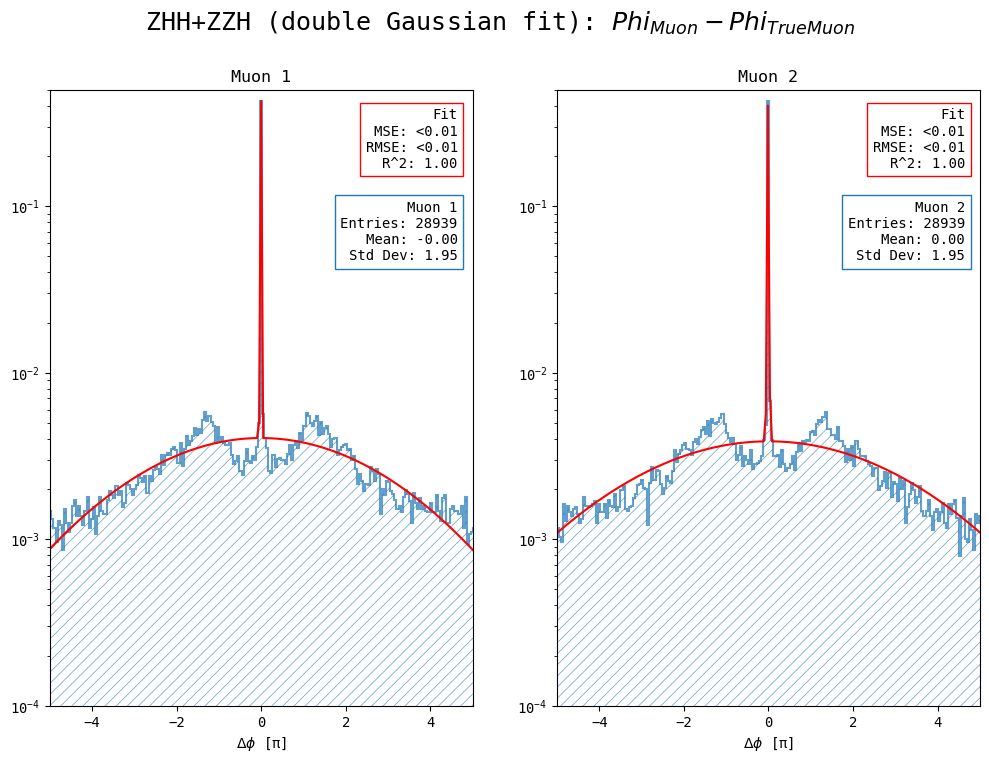

In [114]:
dg = []
fit_init = []
for i in range(2):
    dg.append((df[i][1]["lep"], df[i][1]["true_lep"]))
    fit_init.append([0, 0.1, 0.08, 0, 0.8])

plot_transfer(dg, "ZHH+ZZH (double Gaussian fit)", fit="dbgauss_old", quantity="Phi", xlabel=r"$\Delta\phi$ [π]", true_label="True Muon", reco_label="Muon", fit_init=fit_init, xlim=(-5,5), ylim=(0.0001, 0.5), n_bins=256, yscale="log")

In [149]:
from itertools import permutations
from scipy.optimize import least_squares

ETF_coeffs_sig = [
    (-1.33850763, 6.35057887),
    (-1.36678223, 6.4788703 ),
    (-1.42685018, 6.48213426),
    (-1.20858859, 6.40604084)
]

ETF_coeffs_bkg = [
    (-0.21426421, 5.4111742 ),
    (-0.07810281, 5.41453075),
    (-1.30328320, 6.58035589),
    (-1.23814498, 6.50253684)
]

constants["prob_norm"] = 1/(2**20)/(pi**14)

def lorentz(x, x0, gamma):
    return 1/(pi*gamma*(1 + ( (x-x0)/gamma )**2 ))

def P_calc(kinematics_tf, constants:dict, ETF_params:list, mode:int, corrections:dict = {}) -> float:
    energies, momenta, angles = kinematics_tf

    # Take measured energies as initial guess
    res = construct_func(kinematics_tf, constants, corrections)
    if res is None:
        return -1.
    
    target, guess = res

    #print(guess, target(guess))

    # Solve four momentum conservation
    res = least_squares(target, guess, bounds = (
        (0, 0, 0, 0),
        (500, 500, 500, 500)
    ))
    
    # Truth energies and impulses as calculated from above assumptions/fit
    masses_energies = [
        (constants["m_mu"], energies[0]),
        (constants["m_mu"], energies[1]),
        (constants["m_b"], res.x[0]),
        (constants["m_b"], res.x[1]),
        (constants["m_b"], res.x[2]),
        (constants["m_b"], res.x[3])
    ]
    
    if False:
        print([
            (res.x[0], energies[2]),
            (res.x[1], energies[3]),
            (res.x[2], energies[4]),
            (res.x[3], energies[5])
        ])
    
    # Construct parton impulses from solved energies and take muon energy+angles(momenta) as well measured; i.e. all properties well measured
    kinematics_me = []
    for i in range(6):
        # Infer rho_mu from energy or directly from measurement?
        # Here, assume energy is better measured than magnitude of impulse
        m, E = masses_energies[i]
        
        rho   = sqrt(E**2 - m**2)
        theta = angles[i][0]
        phi   = angles[i][1]
        
        px = rho*sin(theta)*cos(phi)
        py = rho*sin(theta)*sin(phi)
        pz = rho*cos(theta)
        
        kinematics_me.append(E)
        kinematics_me.append(px)
        kinematics_me.append(py)
        kinematics_me.append(pz)

    # Calculate ME**2
    me_squared = (calc_zhh if mode == 1 else calc_zzh)(kinematics_me)[0]
    
    ETFs = np.zeros(24) # energy transfer functions
    perms_part = list(permutations([0, 1, 2, 3]))
    j = 0

    for perm_part in perms_part:
        ETF = 0
        
        #E_jets  = np.array([energies[2+i] for i in range(4)])
        #E_parts = np.array([res.x[perm_part[i]] for i in range(4)])
        
        #E_diffs  = E_jets - E_parts
        
        #x0 = ETF_params[perm_part[i]]
        
        ETFs_perm = np.zeros(4)
        for i in range(4):
            E_jet  = energies[2+i]
            E_part = res.x[perm_part[i]]
            ETFs_perm[i] = lorentz(E_jet - E_part, *ETF_params[perm_part[i]])
            
        ETFs[j] = np.prod(ETFs_perm)
        j += 1
    
    return constants["prob_norm"]/constants["sigma_sig_tot" if mode == 1 else "sigma_bkg_tot"]*me_squared*1/24*ETFs.sum()
    
def P_sig(kinematics_tf, constants:dict, ETF_params:list, corrections:dict = {}) -> float:
    return P_calc(kinematics_tf, constants, ETF_params, 1, corrections)

def P_bkg(kinematics_tf, constants:dict, ETF_params:list, corrections:dict = {}) -> float:
    return P_calc(kinematics_tf, constants, ETF_params, 0, corrections)

event_idx = 10
use_reco  = 1

In [150]:
P_sig(get_kinematics_tf(reco, event_idx, use_reco), constants, ETF_coeffs_sig) # get_corrections(reco, event_idx)

1.045446634803056e-13

In [151]:
P_bkg(get_kinematics_tf(reco, event_idx, use_reco), constants, ETF_coeffs_bkg)

1.045446634803056e-13

In [1]:
length = 1000

P_sigs = np.zeros(2*length)
P_bkgs = np.zeros(2*length)

for i in tqdm(range(2*length)):
    kin  = get_kinematics_tf(reco, i, 0)
    corr = get_corrections(reco, i)
    
    P_sigs[i] = P_sig(kin, constants, ETF_coeffs_sig, corr)
    P_bkgs[i] = P_bkg(kin, constants, ETF_coeffs_bkg, corr)

NameError: name 'np' is not defined

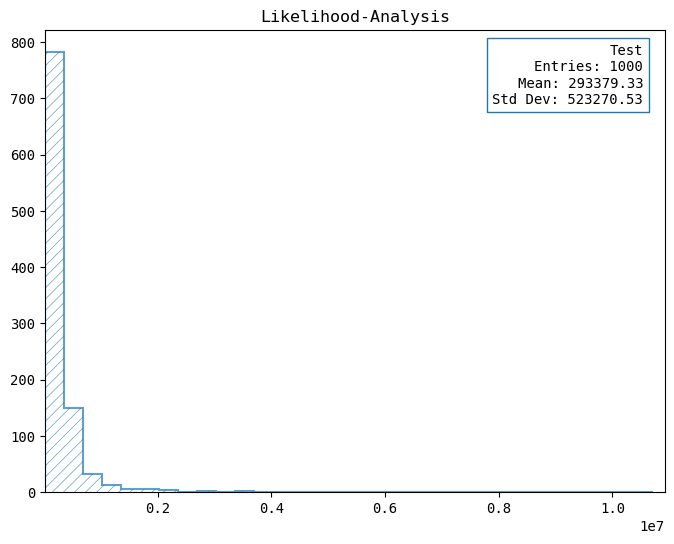

In [223]:
plot_hist(P_sigs/P_bkgs, x="Test", bins=32)

In [323]:
c = root_to_numpy("C:\DevRepositories\MEM_HEP\compare_out.root", "dataTree", merge_with_np_array=a, join_by=["run", "event"], merge_columns=["zzh_h_e"])

('zzh_h_e', 'float32')


<Axes: xlabel='misclustering_region_icns', ylabel='count'>

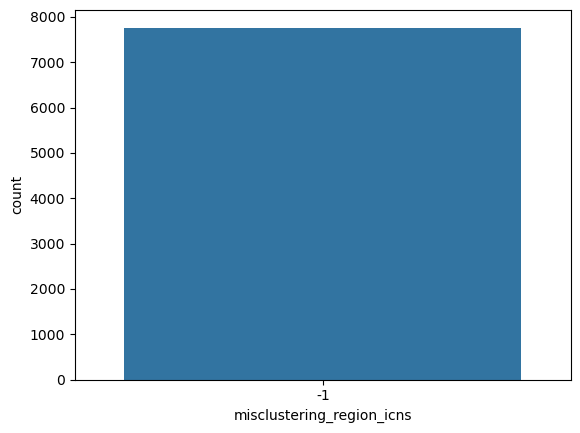

In [11]:
sns.countplot(data_reco, x="misclustering_region_icns")

<Axes: xlabel='efrac2_reco', ylabel='efrac2_true'>

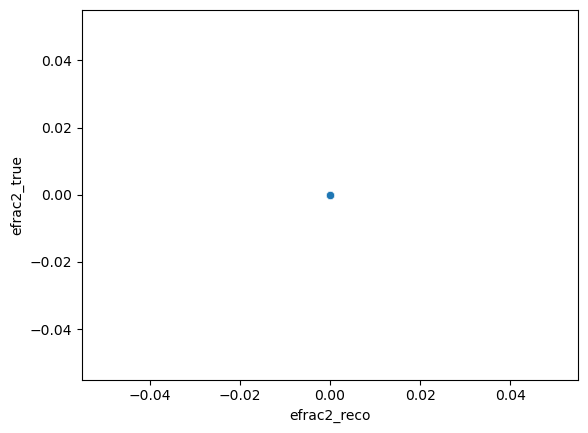

In [7]:
sns.scatterplot(data_reco, x="efrac1_reco", y="efrac1_true")

Comparing all (raw) and filtered (data) events

Text(0.5, 1.0, 'TrueJet / ZZH')

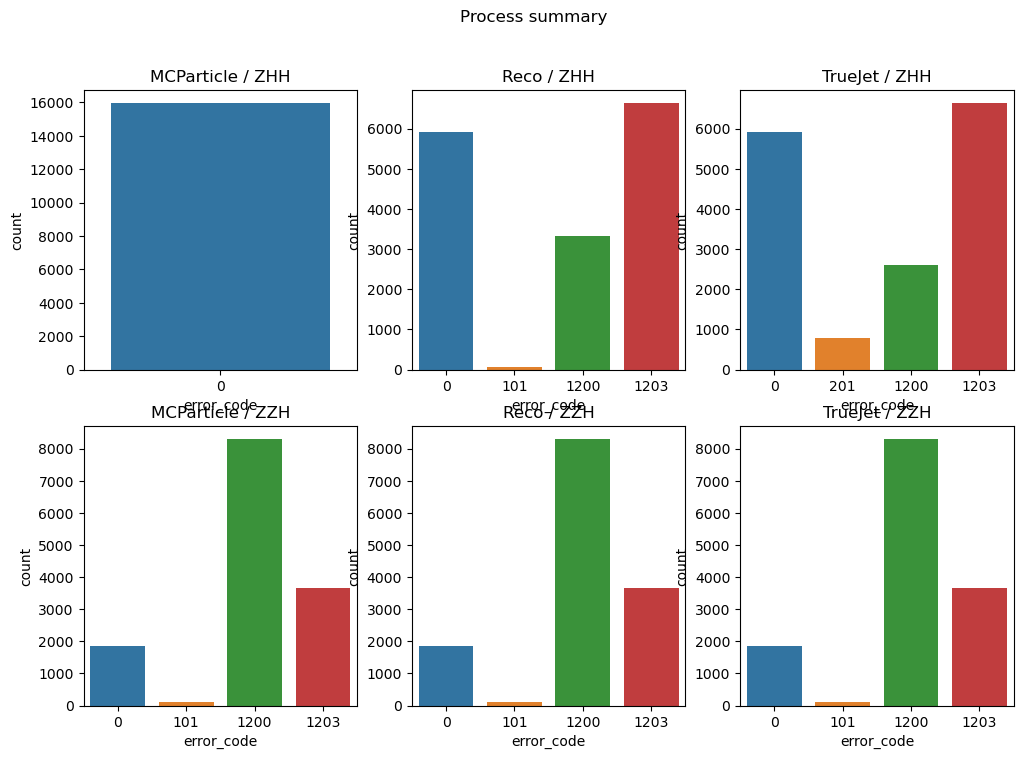

In [8]:
fig, ((ax11, ax12, ax13), (ax21, ax22, ax23)) = plt.subplots(2, 3, figsize=(12,8))
fig.suptitle("Process summary")

fig1 = sns.countplot(raw_mcparticle[raw_mcparticle["is_zhh"] == 1], x="error_code", ax=ax11)
fig1.set_title("MCParticle / ZHH")

fig2 = sns.countplot(raw_reco[raw_reco["is_zhh"] == 1], x="error_code", ax=ax12)
fig2.set_title("Reco / ZHH")

fig3 = sns.countplot(raw_truejet[raw_truejet["is_zhh"] == 1], x="error_code", ax=ax13)
fig3.set_title("TrueJet / ZHH")

fig4 = sns.countplot(raw_reco[raw_reco["is_zzh"] == 1], x="error_code", ax=ax21)
fig4.set_title("MCParticle / ZZH")

fig5 = sns.countplot(raw_reco[raw_reco["is_zzh"] == 1], x="error_code", ax=ax22)
fig5.set_title("Reco / ZZH")

fig6 = sns.countplot(raw_reco[raw_reco["is_zzh"] == 1], x="error_code", ax=ax23)
fig6.set_title("TrueJet / ZZH")

<Axes: xlabel='zzh_nll', ylabel='Count'>

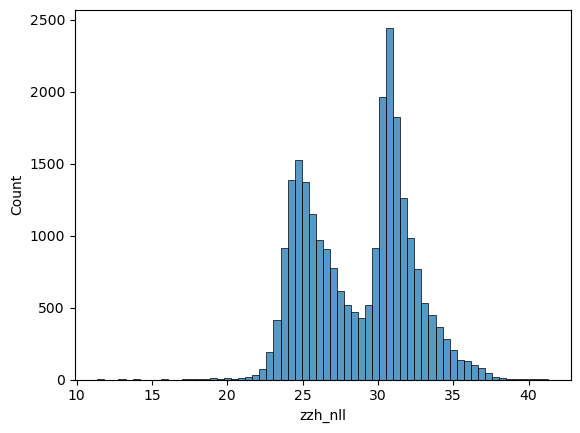

In [7]:
sns.histplot(data_mcparticle, x="zzh_nll", bins=64)

<Axes: xlabel='h1_decay_pdg', ylabel='count'>

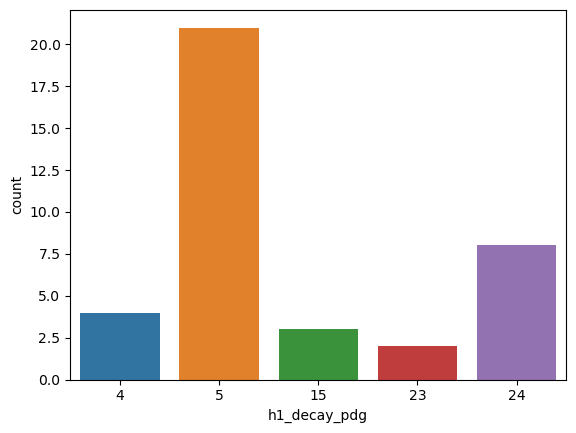

In [13]:
sns.countplot(data_mcparticle[(data_mcparticle["is_zzh"] == 1) & (data_mcparticle["error_code"] == 0)], x="h1_decay_pdg")

1. MCTruth

In [6]:
true_zzh = data_mcparticle[(data_mcparticle["is_zzh"] == 1) & (data_mcparticle["zhh_sigma"] > 0) & (data_mcparticle["zzh_sigma"] > 0)].copy()
true_zhh = data_mcparticle[(data_mcparticle["is_zhh"] == 1) & (data_mcparticle["zhh_sigma"] > 0) & (data_mcparticle["zzh_sigma"] > 0)].copy()

true_zzh.reset_index(drop=True,inplace=True)
true_zhh.reset_index(drop=True,inplace=True)

llr = combine_columns({ "zhh_llr": true_zhh["llr"], "zzh_llr": true_zzh["llr"] })

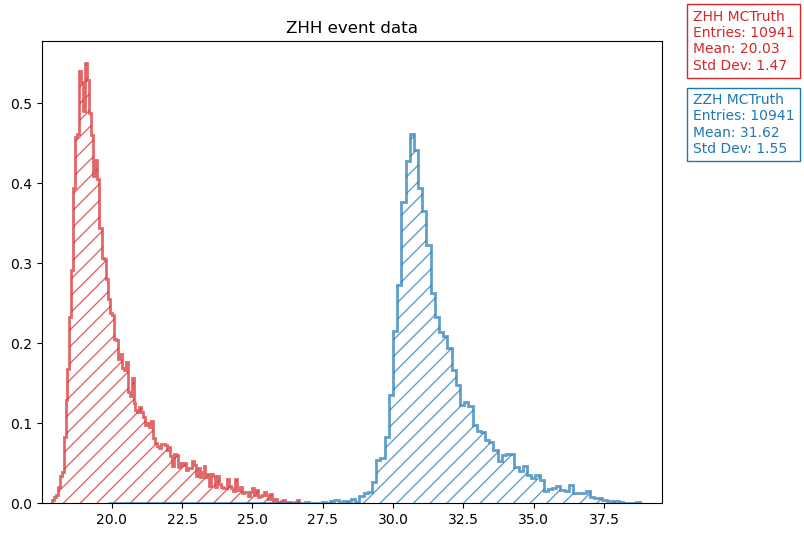

In [40]:
plot_hist(true_zhh, x = ["zhh_nll", "zzh_nll"], title="ZHH event data", normalize=True, labels=["ZHH MCTruth", "ZZH MCTruth"], xlabel="nll")

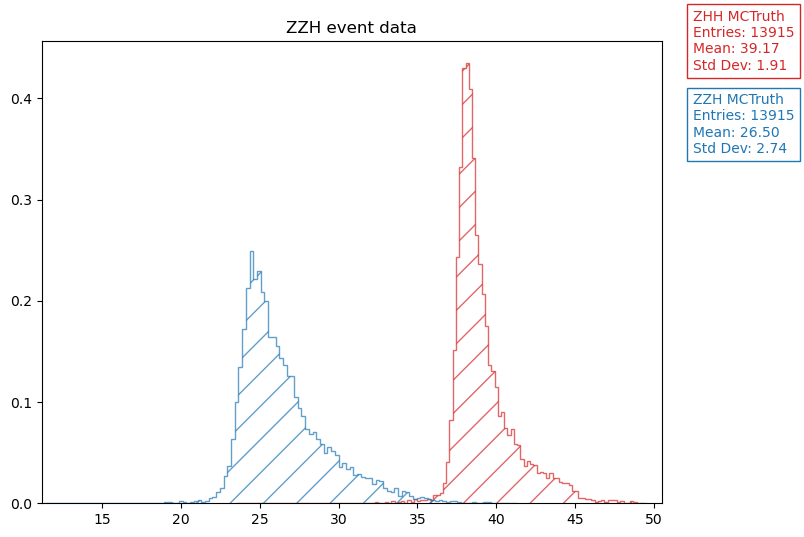

In [36]:
plot_hist(true_zzh, x = ["zhh_nll", "zzh_nll"], title="ZZH event data", normalize=True, labels=["ZHH MCTruth", "ZZH MCTruth"], xlabel="nll")

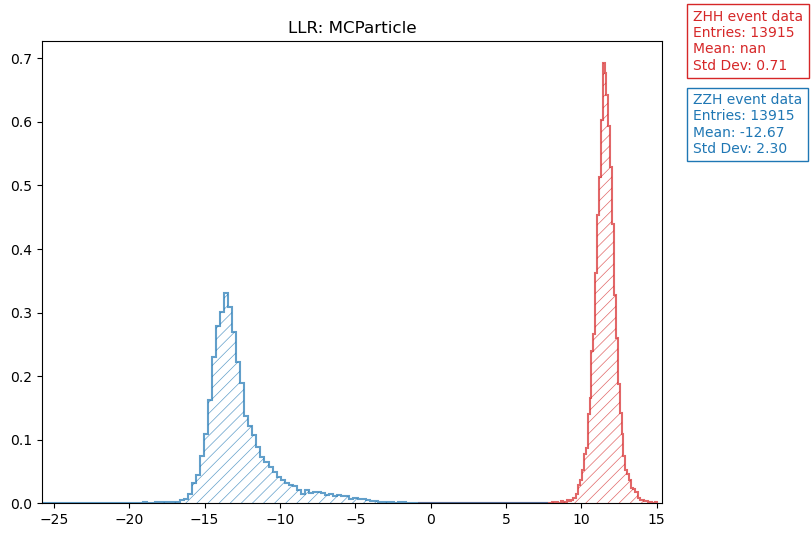

In [7]:
plot_hist(llr, x = ["zhh_llr", "zzh_llr"], labels=["ZHH event data", "ZZH event data"], title="LLR: MCParticle", normalize=True, xlabel="llr")

2. RefinedJets

In [55]:
true_zzh = data_reco[(data_reco["is_zzh"] == 1) & (data_reco["zhh_sigmalr"] > 0) & (data_reco["zzh_sigmalr"] > 0)].copy()
true_zhh = data_reco[(data_reco["is_zhh"] == 1) & (data_reco["zhh_sigmalr"] > 0) & (data_reco["zzh_sigmalr"] > 0)].copy()

true_zzh.reset_index(drop=True,inplace=True)
true_zhh.reset_index(drop=True,inplace=True)

llr = combine_columns({ "zhh_llr": true_zhh["llr"], "zzh_llr": true_zzh["llr"] })

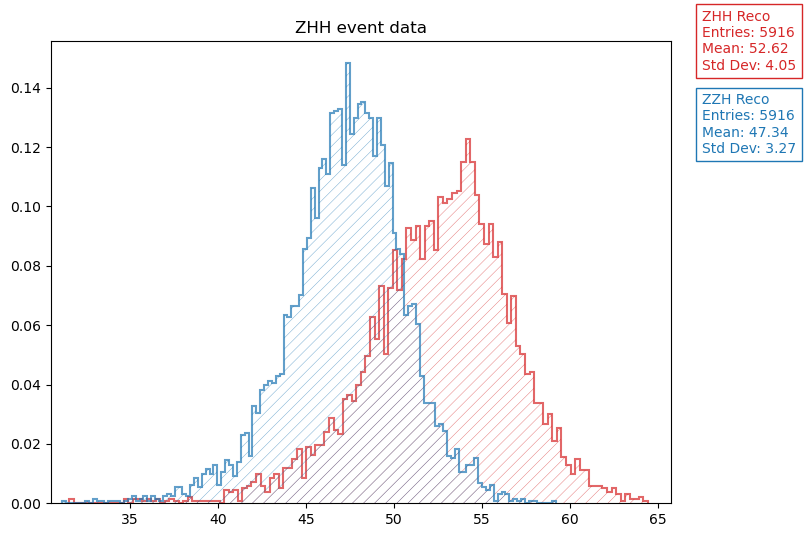

In [57]:
plot_hist(true_zhh, x = ["zhh_nll", "zzh_nll"], title="ZHH event data", normalize=True, labels=["ZHH Reco", "ZZH Reco"], xlabel="nll")

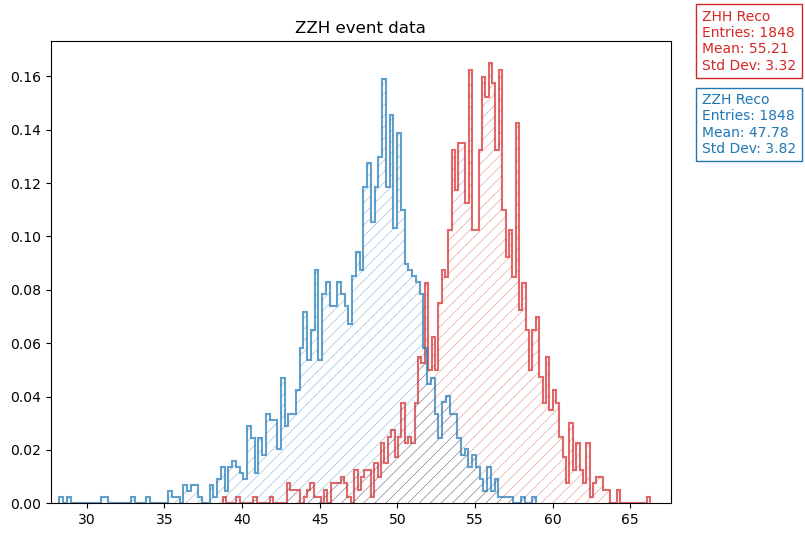

In [58]:
plot_hist(true_zzh, x = ["zhh_nll", "zzh_nll"], title="ZZH event data", normalize=True, labels=["ZHH Reco", "ZZH Reco"], xlabel="nll")

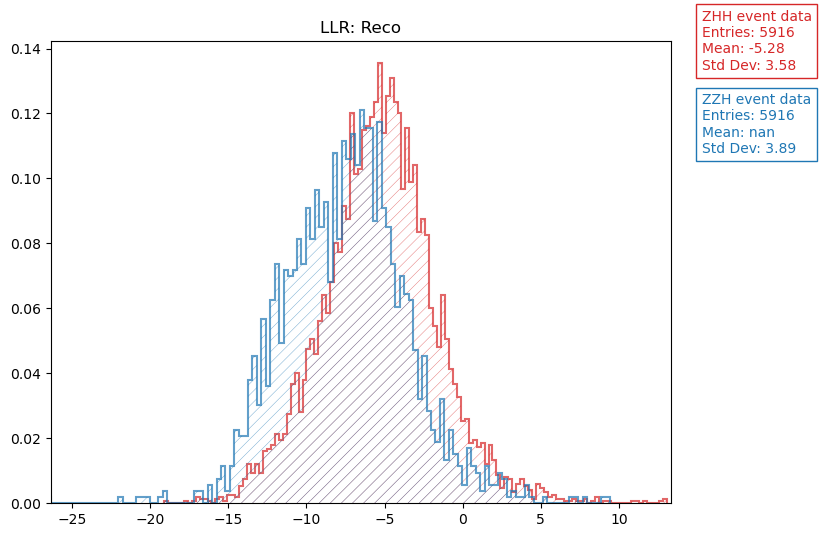

In [59]:
plot_hist(llr, x = ["zhh_llr", "zzh_llr"], labels=["ZHH event data", "ZZH event data"], title="LLR: Reco", normalize=True, xlabel="llr")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_name
Warning in <TROOT::Append>: Replacing existing TH1: ZHH event data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ZZH event data (Potential memory leak).


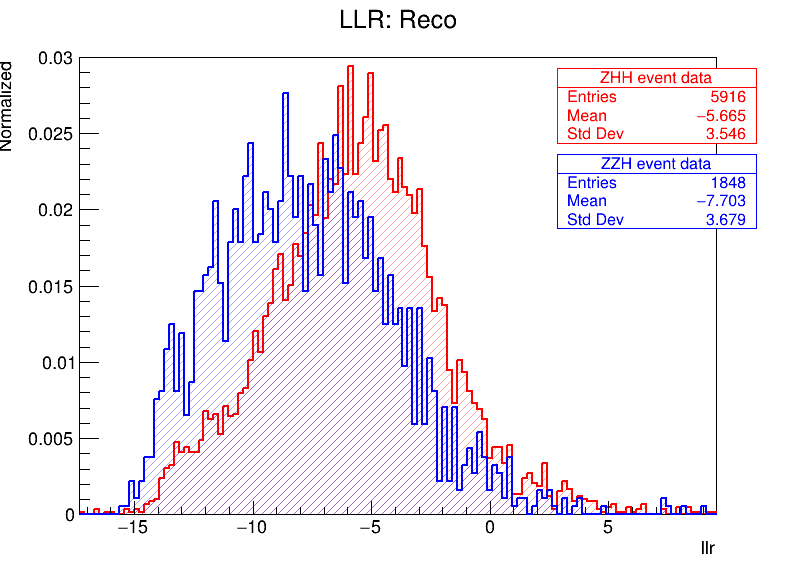

In [ ]:
plot_hist(llr, x = ["zhh_llr", "zzh_llr"], labels=["ZHH event data", "ZZH event data"], title="LLR: Reco", normalize=True, xlabel="llr")

3. TrueJet

In [60]:
true_zzh = data_truejet[(data_truejet["is_zzh"] == 1) & (data_truejet["zhh_sigmalr"] > 0) & (data_truejet["zzh_sigmalr"] > 0)].copy()
true_zhh = data_truejet[(data_truejet["is_zhh"] == 1) & (data_truejet["zhh_sigmalr"] > 0) & (data_truejet["zzh_sigmalr"] > 0)].copy()

true_zzh.reset_index(drop=True,inplace=True)
true_zhh.reset_index(drop=True,inplace=True)

llr = combine_columns({ "zhh_llr": true_zhh["llr"], "zzh_llr": true_zzh["llr"] })

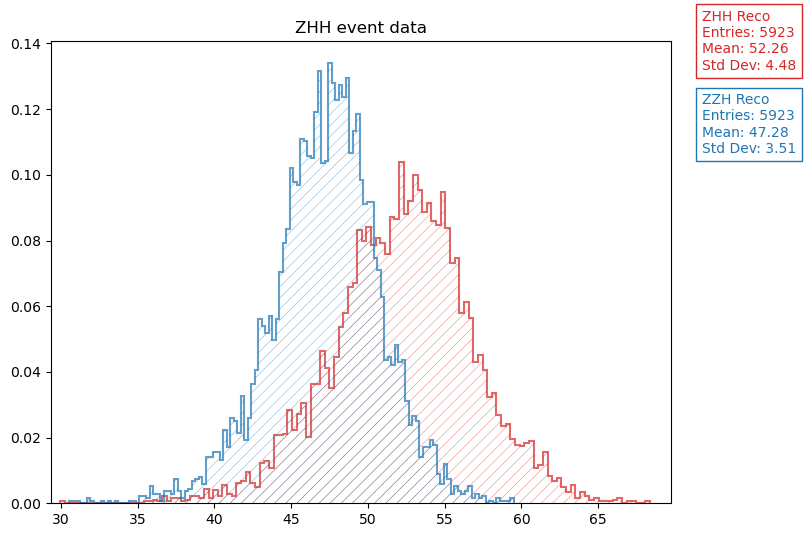

In [61]:
plot_hist(true_zhh, x = ["zhh_nll", "zzh_nll"], title="ZHH event data", normalize=True, labels=["ZHH Reco", "ZZH Reco"], xlabel="nll")

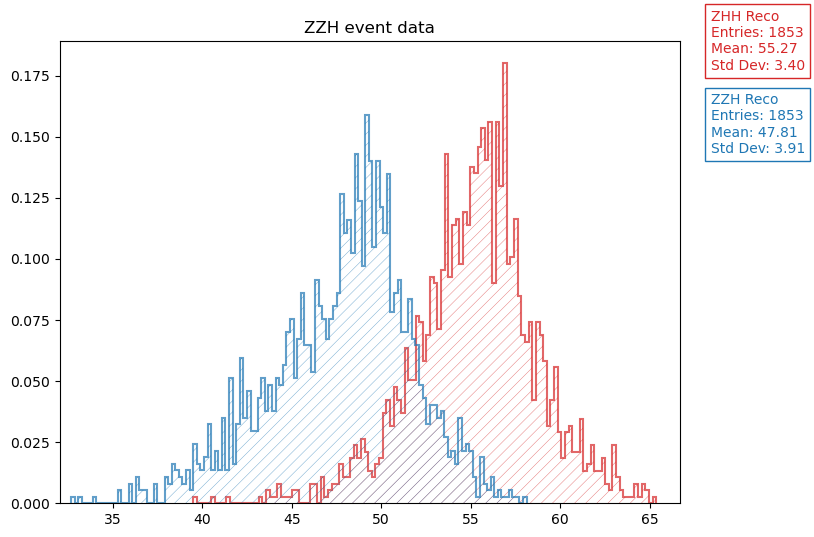

In [62]:
plot_hist(true_zzh, x = ["zhh_nll", "zzh_nll"], title="ZZH event data", normalize=True, labels=["ZHH Reco", "ZZH Reco"], xlabel="nll")

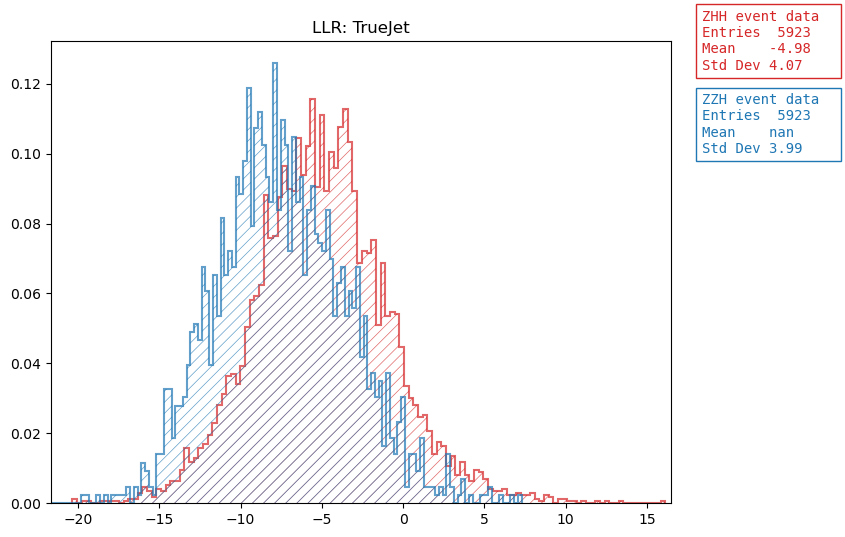

In [85]:
plot_hist(llr, x = ["zhh_llr", "zzh_llr"], labels=["ZHH event data", "ZZH event data"], title="LLR: TrueJet", normalize=True, xlabel="llr")

Region A

<Axes: xlabel='true_type', ylabel='count'>

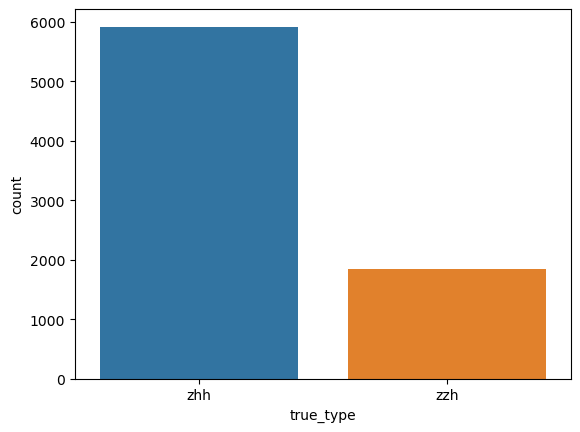

: 

In [ ]:
sns.countplot(data_reco, x="true_type")

<Axes: xlabel='misclustering_region_icns', ylabel='count'>

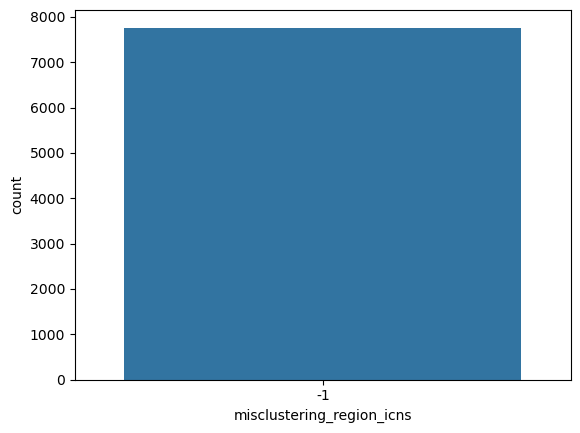

In [14]:
sns.countplot(data_reco, x="misclustering_region") # {"AA",0.}, {"AB",1.}, {"AC",2.}, {"AD",3.}, {"BB",4.}, {"BC",5.}, {"BD",6.}, {"CC",7.}, {"CD",8.}, {"DD",9.}